In [1]:
%load_ext autoreload
%autoreload 2

import pickle
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
from corner import corner
from tqdm.auto import tqdm, trange
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
from scipy.optimize import minimize_scalar

import jax
import jax.numpy as jnp
from jax import random

from pydd.binary import *
from pydd.analysis import *
from pydd.noise import *

In [ ]:
# # Discoverable system
# m_1 = jnp.array(1e3 * MSUN)
# m_2 = jnp.array(1 * MSUN)
# rho_s = jnp.array(1e-7 * MSUN / PC ** 3)
# gamma_s = jnp.array(7/3)
# dd_s = make_dynamic_dress(m_1, m_2, rho_s, gamma_s)
# dd_v = VacuumBinary(dd_s.M_chirp, dd_s.Phi_c, dd_s.tT_c, dd_s.dL_iota, dd_s.f_c)

# t_obs_lisa = 5 * YR
# f_l = minimize_scalar(
#     lambda f: (t_to_c(f, dd_s) - t_obs_lisa) ** 2, bracket=(1e-4, 1e-1)
# ).x
# f_c = dd_s.f_c

# # Dephasing
# dN = (Phi_to_c(f_l, dd_v) - Phi_to_c(f_l, dd_s)) / (2 * pi)
# print(f"dN (naive): {dN}")

In [2]:
# Measurable system
m_1 = jnp.array(1e3 * MSUN)
m_2 = jnp.array(1 * MSUN)
rho_s = jnp.array(226 * MSUN / PC ** 3)
gamma_s = jnp.array(7/3)
dd_s = make_dynamic_dress(m_1, m_2, rho_s, gamma_s)
dd_v = VacuumBinary(dd_s.M_chirp, dd_s.Phi_c, dd_s.tT_c, dd_s.dL_iota, dd_s.f_c)

t_obs_lisa = 5 * YR
f_l = minimize_scalar(
    lambda f: (t_to_c(f, dd_s) - t_obs_lisa) ** 2, bracket=(1e-4, 1e-1)
).x
f_c = dd_s.f_c

# Dephasing
dN = (Phi_to_c(f_l, dd_v) - Phi_to_c(f_l, dd_s)) / (2 * pi)
print(f"dN (naive): {dN}")

dN (naive): 11087.884471777055


## Nested sampling with FFT likelihood (3D)

In [3]:
def logL_3d_fft(x):
    gamma_s, log10_rho_s, M_chirp_MSUN = x
    M_chirp = M_chirp_MSUN * MSUN
    q = dd_s.q
    rho_s = 10**log10_rho_s * MSUN / PC**3
    c_f = get_c_f(get_m_1(M_chirp, q), get_m_2(M_chirp, q), rho_s, gamma_s)
    dd_h = DynamicDress(
        gamma_s,
        c_f,
        M_chirp,
        q,
        dd_s.Phi_c,
        dd_s.tT_c,
        dd_s.dL_iota,
        get_f_isco(get_m_1(M_chirp_MSUN * MSUN, q))
    )
    f_h = jnp.maximum(dd_s.f_c, dd_h.f_c)
    return loglikelihood_fft(dd_h, dd_s, f_l, f_h, 100000, 3000)

In [5]:
# Call to jit compile
x = jnp.array(
    [gamma_s, jnp.log10(rho_s / (MSUN / PC ** 3)), get_M_chirp(m_1, m_2) / MSUN]
)
print(logL_3d_fft(x))
print(logL_3d_fft(x))

42.47661854469314
42.47661854469314


In [12]:
gamma_s_range = [2.25, 2.5]
log10_rho_s_range = [-30, 10]
dM_chirp_MSUN_range = [-1e-3, 1.5e-3]
# q_range = [0.0001, 0.005]

# Sanity checks...
assert gamma_s > gamma_s_range[0] and gamma_s < gamma_s_range[1]
assert rho_s > 10 ** log10_rho_s_range[0] * MSUN / PC ** 3
assert rho_s < 10 ** log10_rho_s_range[1] * MSUN / PC ** 3
assert dM_chirp_MSUN_range[0] < 0 and dM_chirp_MSUN_range[1] > 0

labels = (
    r"$\gamma_s$",
    r"$\log_{10} \frac{\rho_s}{\mathrm{M}_\odot \, \mathrm{pc}^{-3}}$",
    r"$\mathcal{M}$ [M$_\odot$]",
    #     r"$q$",
)


def ptform(u):
    gamma_s = (gamma_s_range[1] - gamma_s_range[0]) * u[0] + gamma_s_range[0]
    log10_rho_s = (log10_rho_s_range[1] - log10_rho_s_range[0]) * u[
        1
    ] + log10_rho_s_range[0]
    dM_chirp_MSUN = (dM_chirp_MSUN_range[1] - dM_chirp_MSUN_range[0]) * u[
        2
    ] + dM_chirp_MSUN_range[0]
    M_chirp = dM_chirp_MSUN + dd_s.M_chirp / MSUN
    return jnp.array([gamma_s, log10_rho_s, M_chirp])

In [13]:
# Test some points to make sure likelihood isn't nan
(
    logL_3d_fft(ptform(jnp.zeros((4,)))),
    logL_3d_fft(ptform(jnp.full((4,), 0.5))),
    logL_3d_fft(ptform(jnp.ones((4,)))),
)

(Buffer(0.30284309, dtype=float64),
 Buffer(1.73450431, dtype=float64),
 Buffer(0.30081223, dtype=float64))

`rho_s` prior goes to `20 * rho_s`

In [14]:
sampler = dynesty.NestedSampler(
    logL_3d_fft, ptform, len(labels), nlive=1000, bound="multi"
)
sampler.run_nested()
results = sampler.results
print(results.summary())

12420it [54:29,  3.80it/s, +1000 | bound: 18 | nc: 1 | ncall: 62155 | eff(%): 21.591 | loglstar:   -inf < 42.471 <    inf | logz: 30.223 +/-  0.158 | dlogz:  0.001 >  1.009]

Summary
nlive: 1000
niter: 12420
ncall: 62155
eff(%): 21.591
logz: 30.223 +/-  0.158
None


In [33]:
# # Save results!
# with open('3d-dynesty-sampler-discoverable.pkl', 'wb') as output:
#     pickle.dump(sampler, output, pickle.HIGHEST_PROTOCOL)

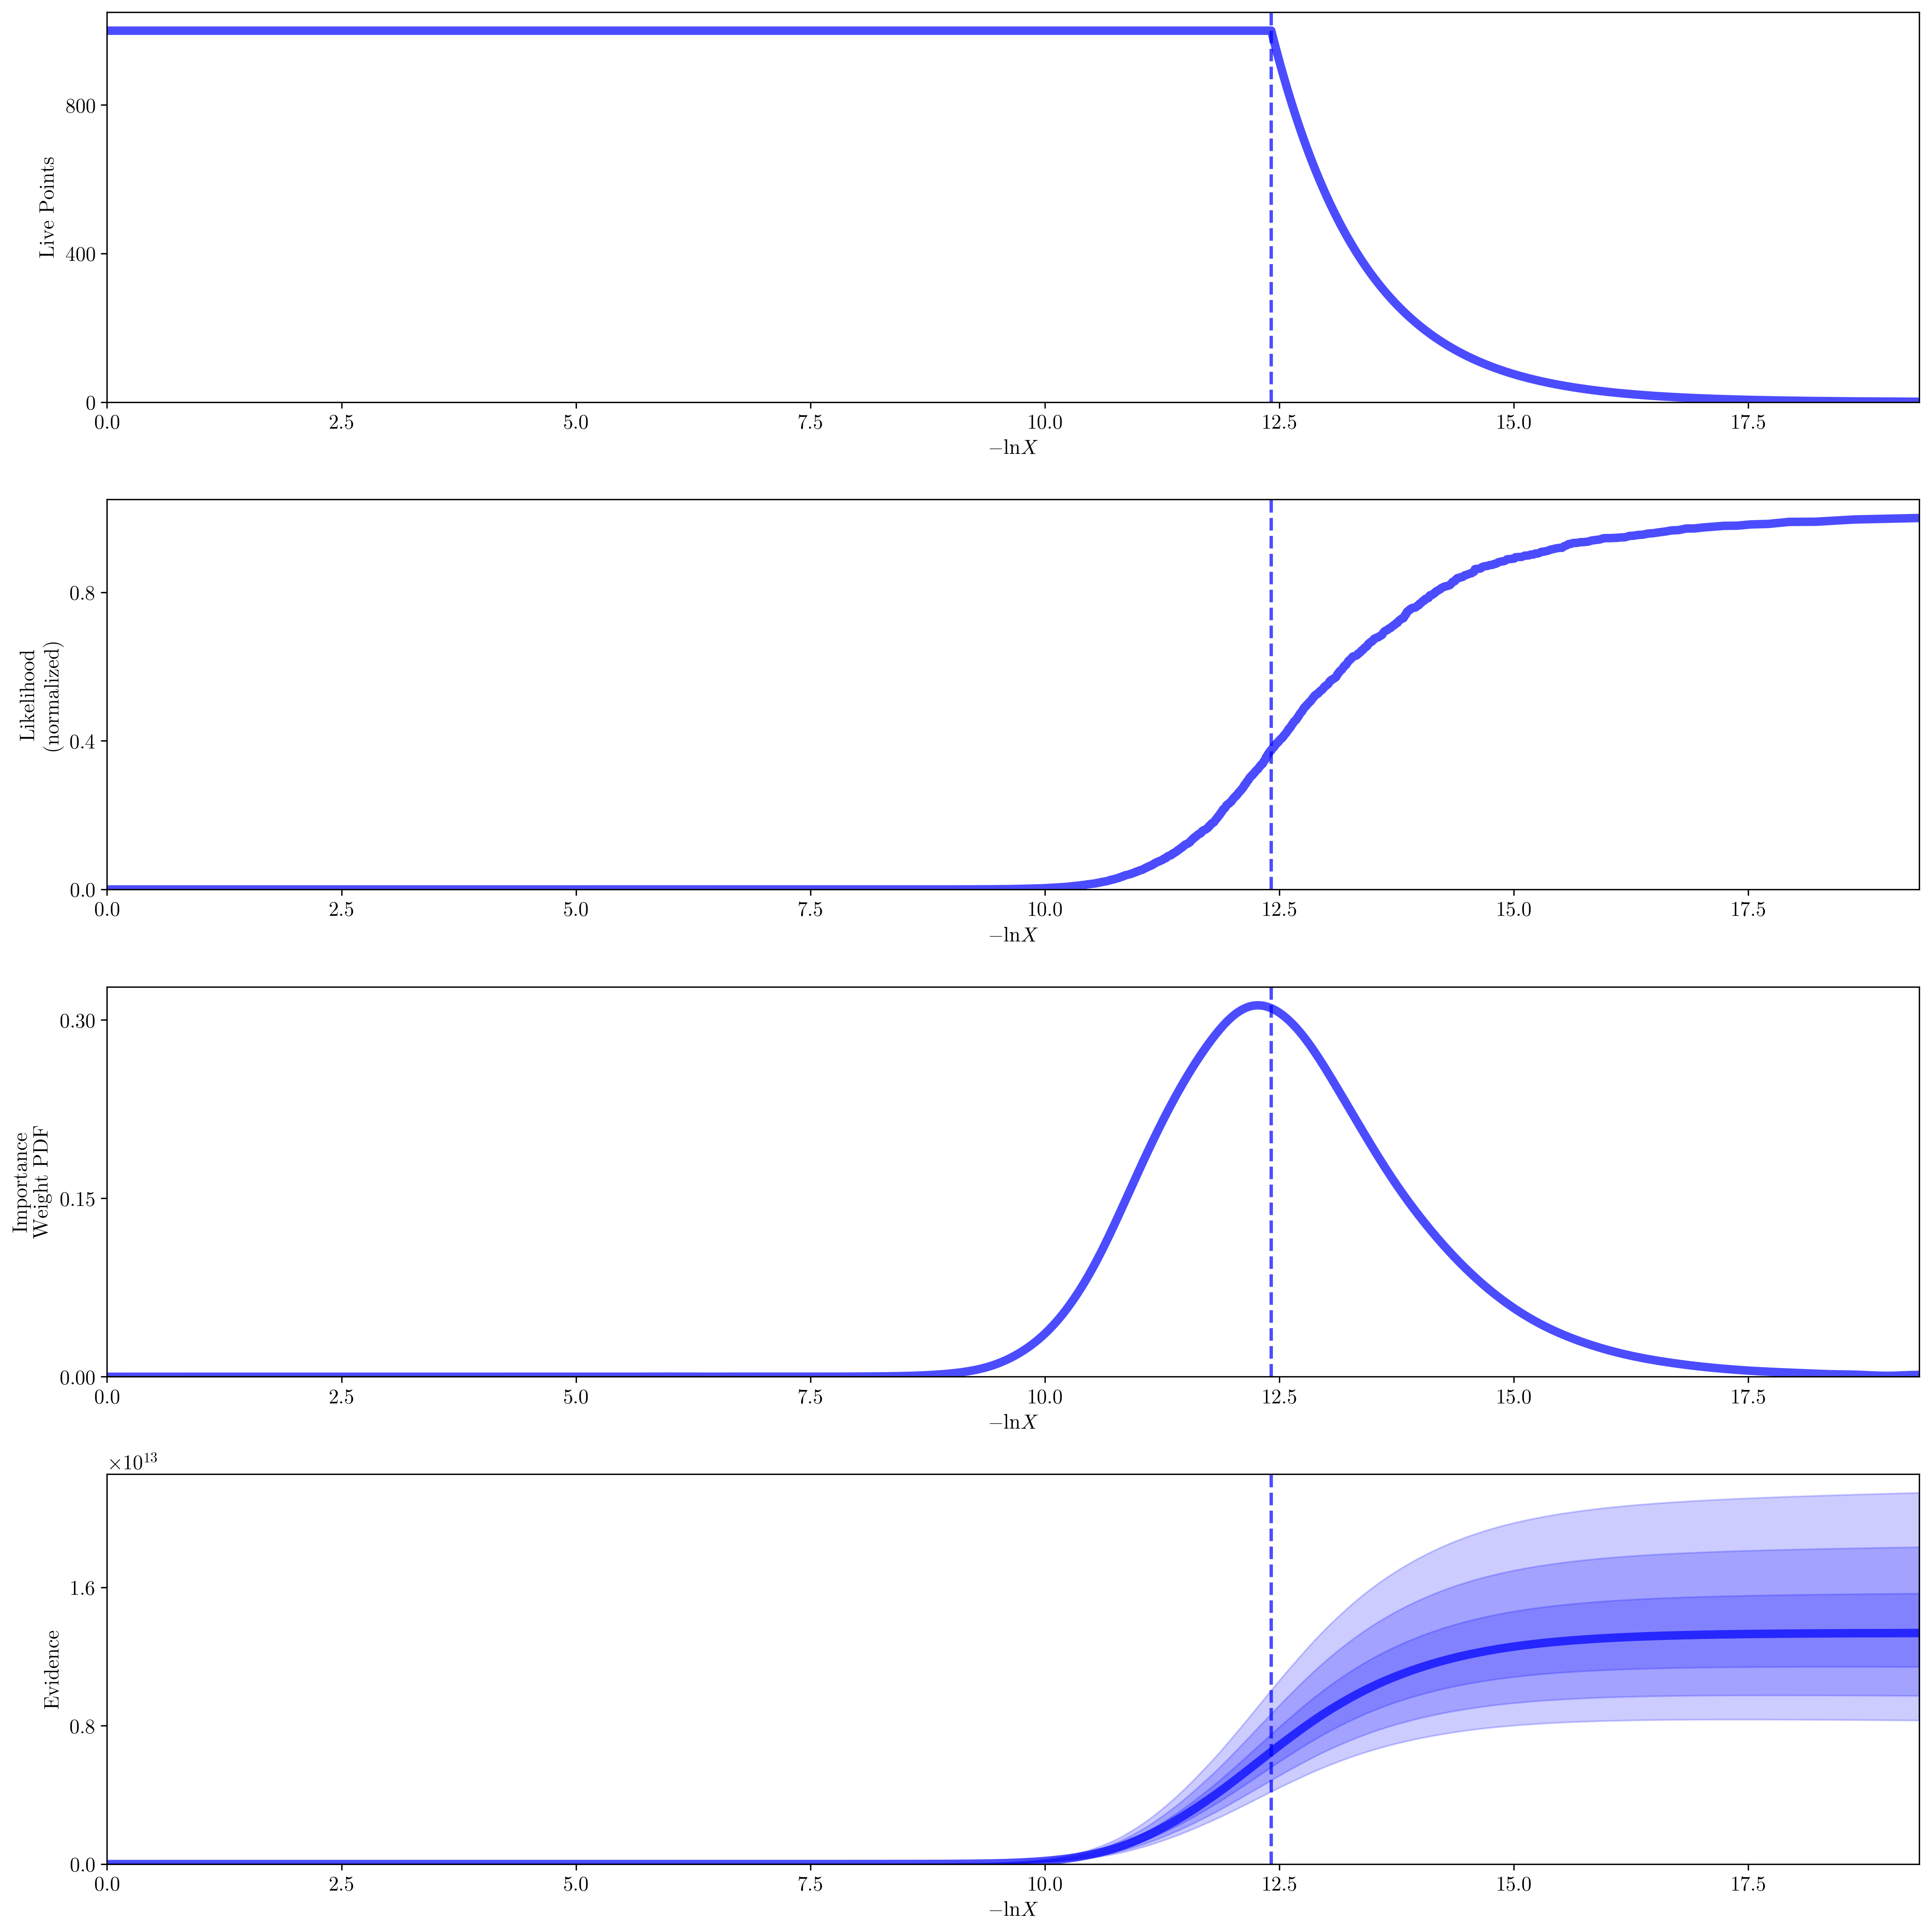

In [16]:
rfig, raxes = dyplot.runplot(results)
rfig.tight_layout()

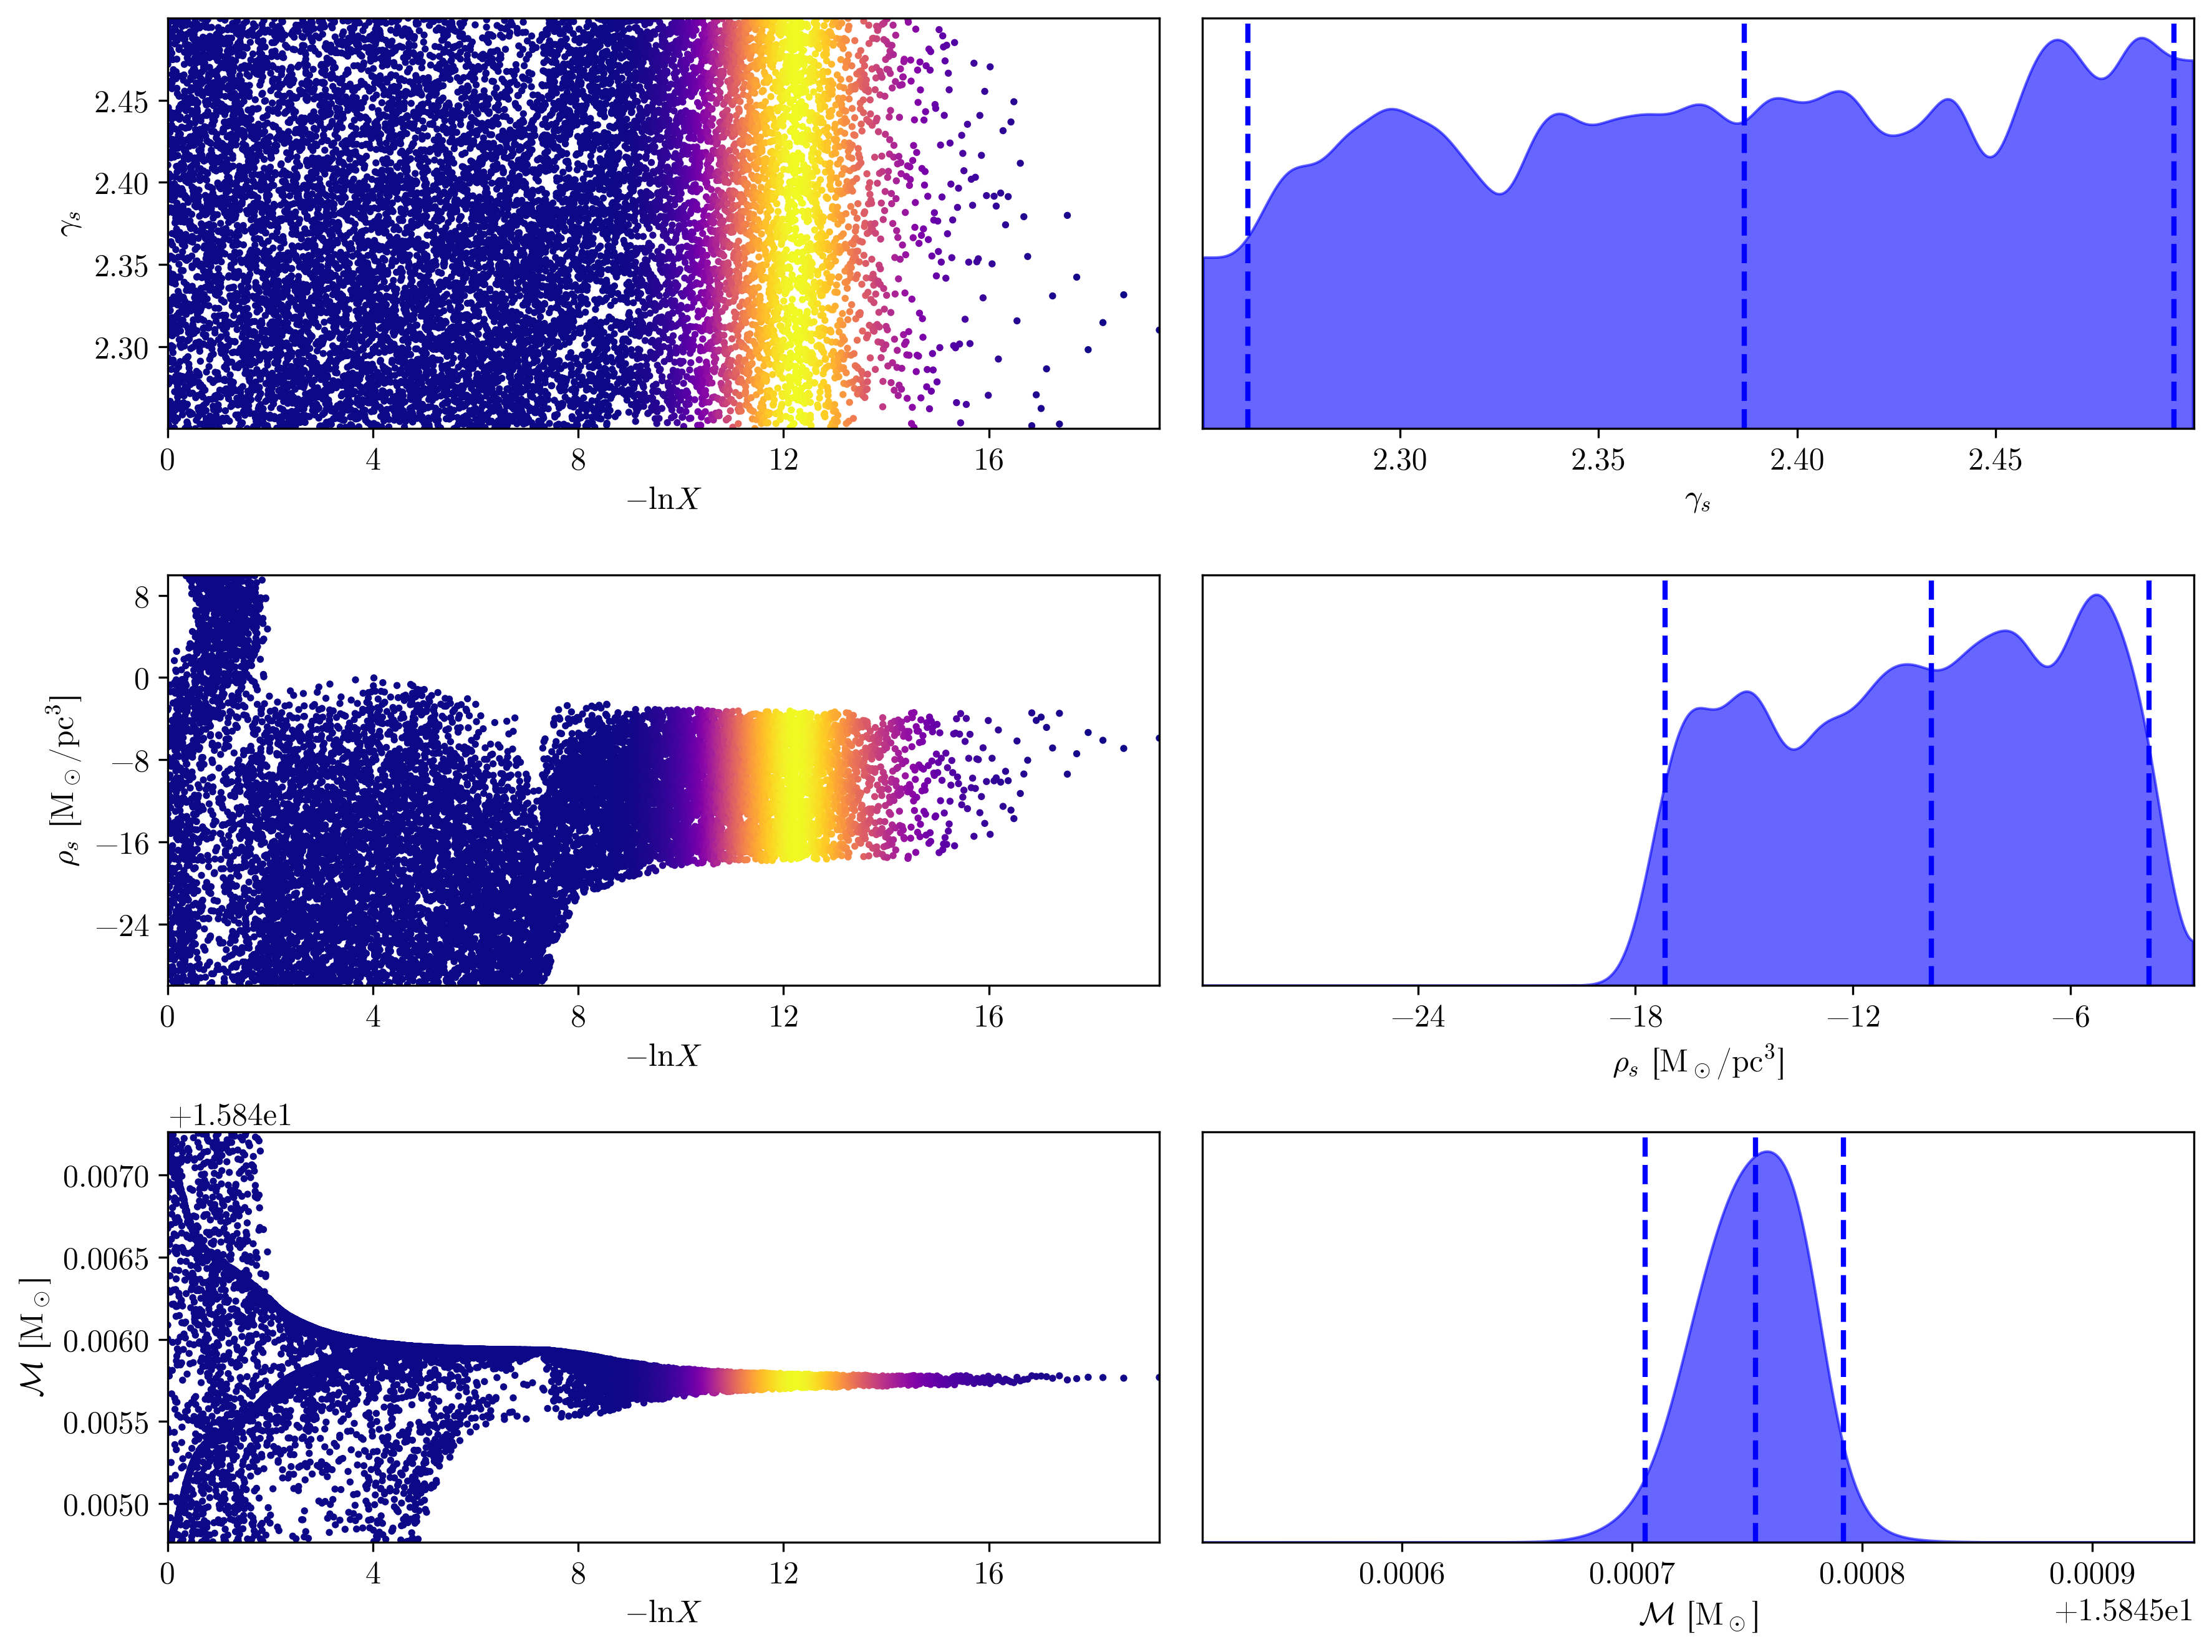

In [17]:
tfig, taxes = dyplot.traceplot(results, labels=labels)
tfig.tight_layout()

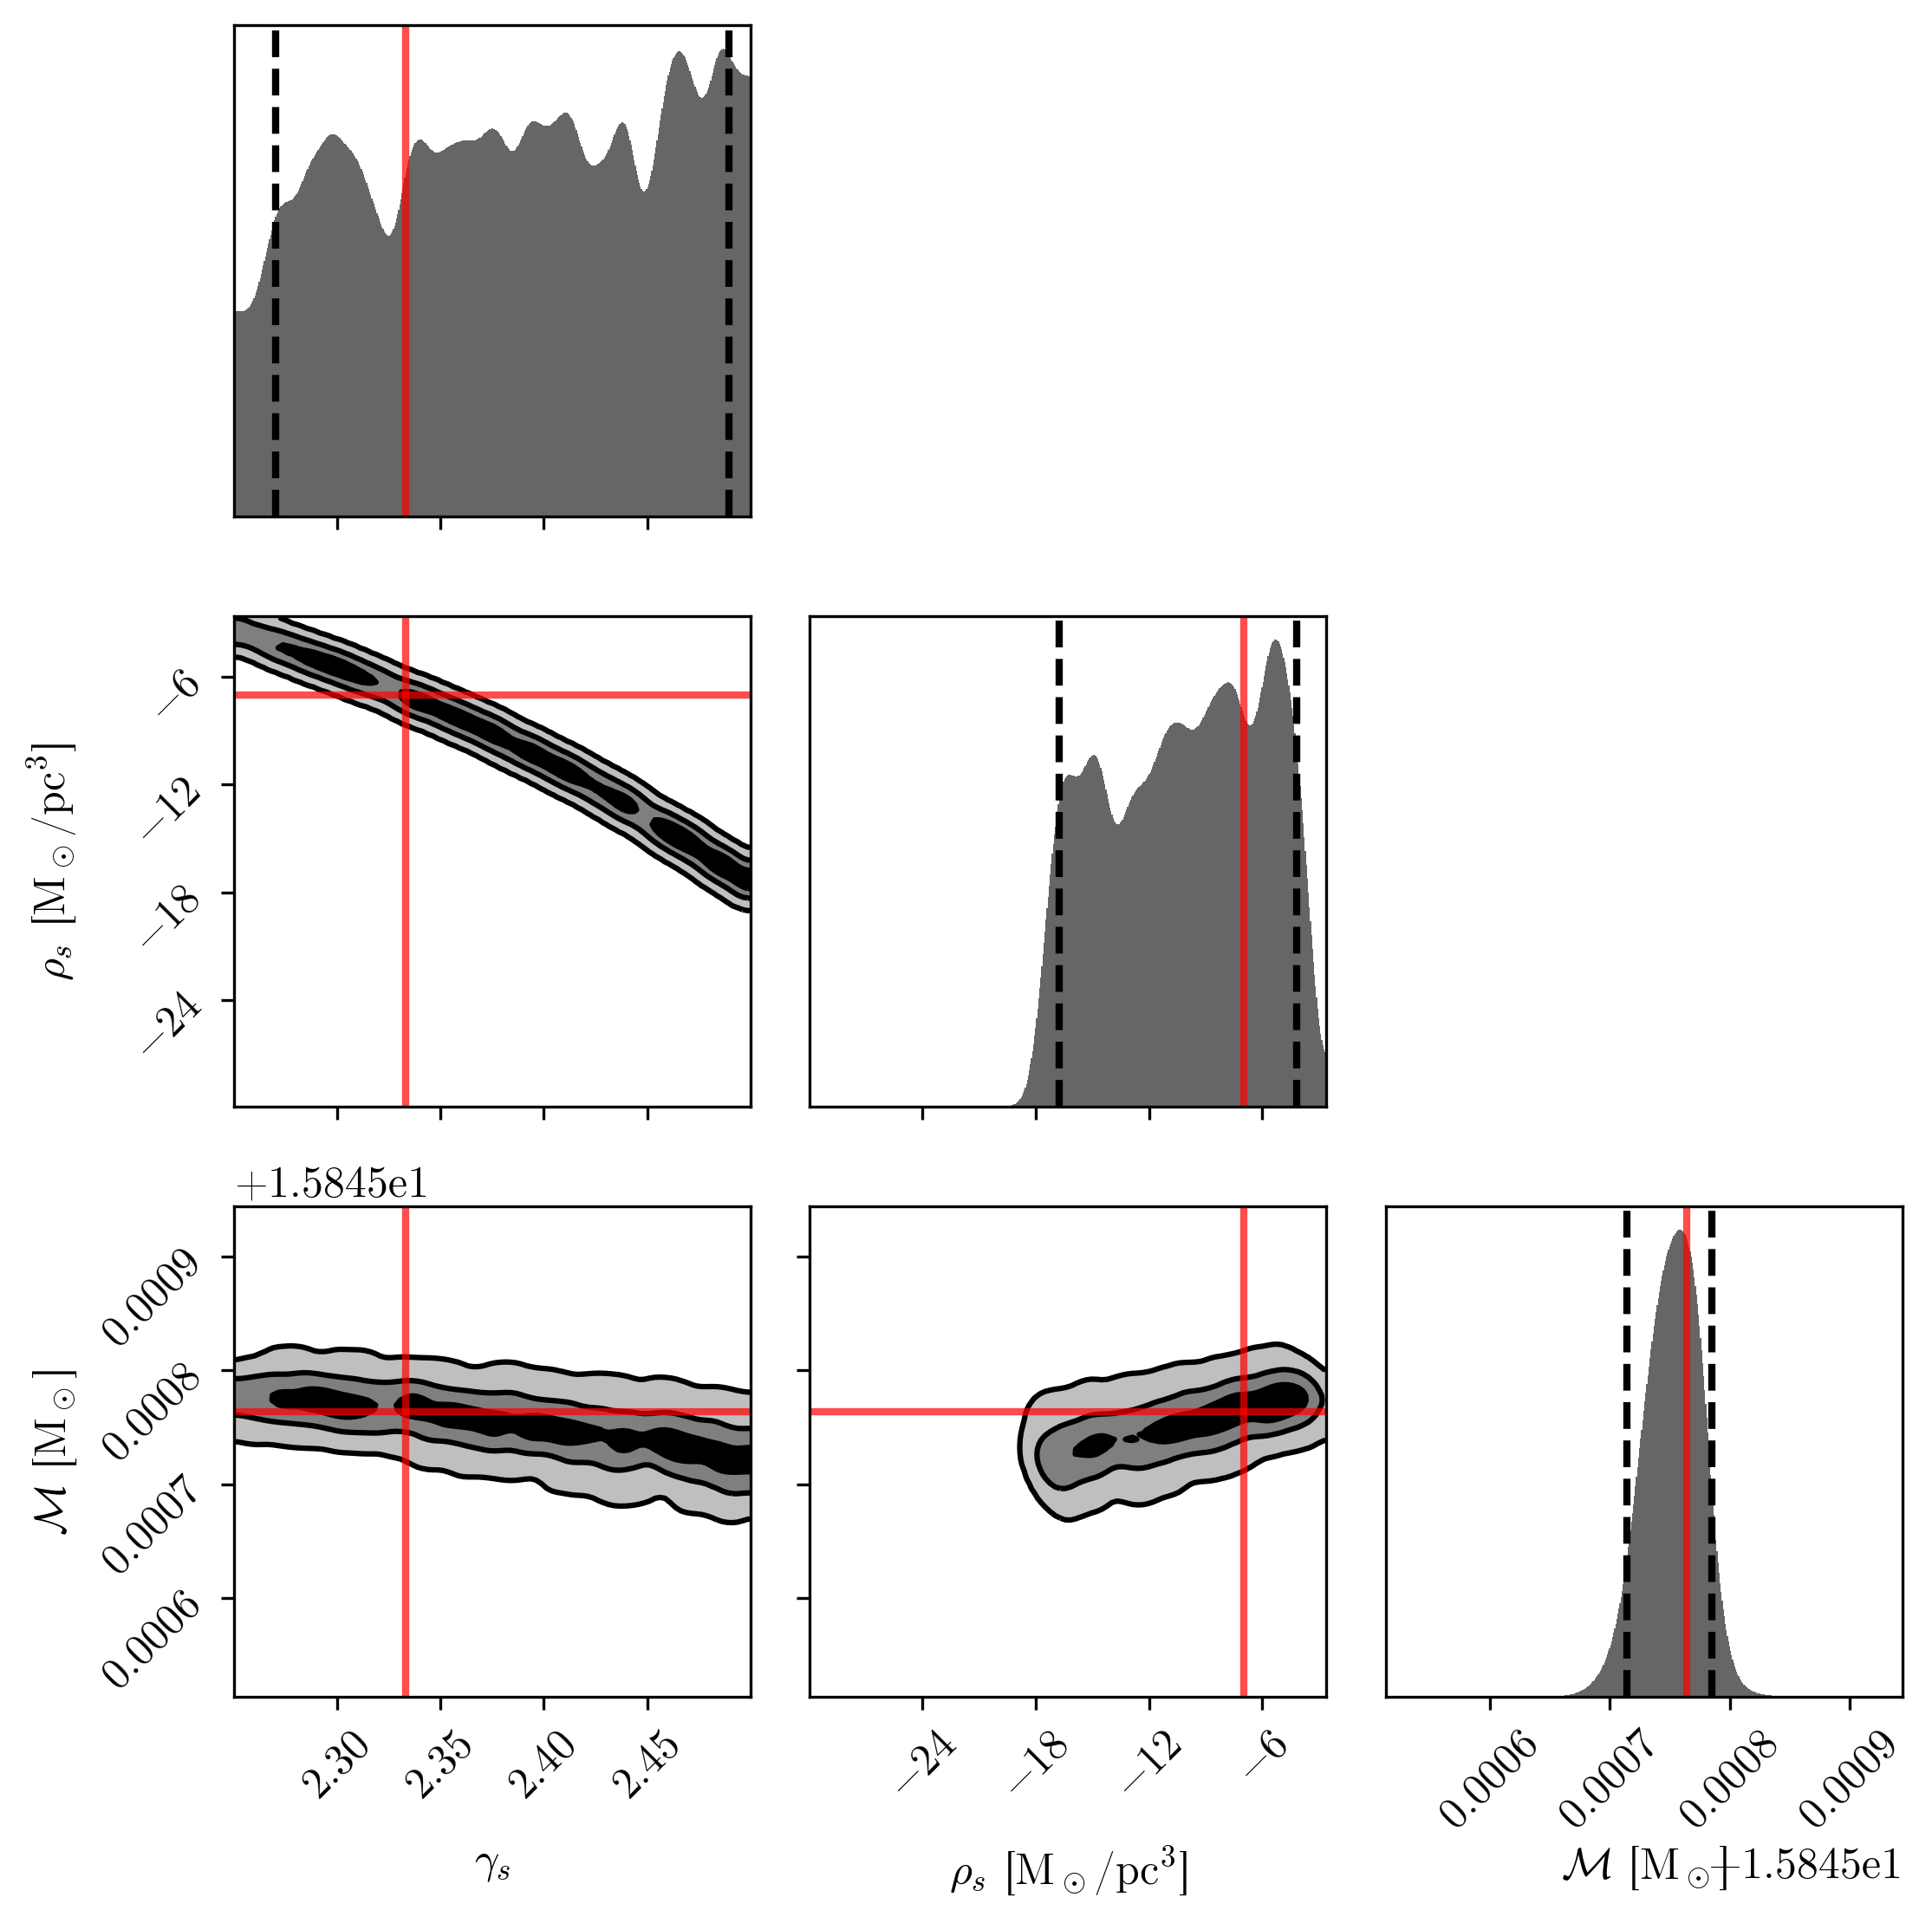

In [20]:
cfig, caxes = dyplot.cornerplot(
    results,
    labels=labels,
    quantiles=[1 - 0.95, 0.95],
    quantiles_2d=[1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]],
    # smooth=0.02,
    # cmap="viridis",
    truths=(gamma_s, jnp.log10(rho_s / (MSUN / PC ** 3)), dd_s.M_chirp / MSUN),
)
cfig.tight_layout()

In [19]:
results["logz"][-1]

30.223396127249124

## Nested sampling with FFT likelihood (4D)

In [3]:
def logL_4d_fft(x):
    gamma_s, rho_s_MSUNPC3, M_chirp_MSUN, log10_q = x
    rho_s = rho_s_MSUNPC3 * MSUN / PC**3
    M_chirp = M_chirp_MSUN * MSUN
    q = 10**log10_q
    c_f = get_c_f(get_m_1(M_chirp, q), get_m_2(M_chirp, q), rho_s, gamma_s)

    dd_h = DynamicDress(
        gamma_s,
        c_f,
        M_chirp,
        q,
        dd_s.Phi_c,
        dd_s.tT_c,
        dd_s.dL_iota,
        get_f_isco(get_m_1(M_chirp_MSUN * MSUN, q))
    )
    
    f_h = jnp.maximum(dd_s.f_c, dd_h.f_c)
    
    return loglikelihood_fft(dd_h, dd_s, f_l, f_h, 100000, 3000)

In [4]:
# Call to jit compile
x = jnp.array(
    [
        gamma_s,
        rho_s / (MSUN / PC ** 3),
        get_M_chirp(m_1, m_2) / MSUN,
        jnp.log10(dd_s.q),
    ]
)
print(logL_4d_fft(x))
print(logL_4d_fft(x))

42.472741953013184
42.472741953013184


In [5]:
# # Measurability
# gamma_s_range = [2.25, 2.5]
# log10_rho_s_range = [0, 1e3]
# dM_chirp_MSUN_range = [-1e-4, 1.5e-4]
# log10_q_range = [-3.5, -2.5]

In [8]:
gamma_s_range = [2.25, 2.5]

# Detectability
# log10_rho_s_range = [-30, 10]
# dM_chirp_MSUN_range = [-1e-3, 1.5e-3]
# log10_q_range = [-4, -2]  # because this is what we can model so far

# Measurability
rho_s_MSUNPC3_range = [1e-50, 1e3]
# Restrict to m1 ~ [1e3, 1e5], m2 ~ [1, 10], and q < 1 / 1e3
log10_q_range = [-3.75, -2.5]
# dM_chirp_min = get_M_chirp(1e3 * MSUN, 1 * MSUN) - dd_s.M_chirp
dM_chirp_max = get_M_chirp(1e5 * MSUN, 10 * MSUN) - dd_s.M_chirp
dM_chirp_MSUN_range = [-6e-3, min(dM_chirp_max / MSUN, 6e-3)]

# Sanity checks...
assert gamma_s > gamma_s_range[0] and gamma_s < gamma_s_range[1]
assert rho_s > rho_s_MSUNPC3_range[0] * MSUN / PC ** 3
assert rho_s < rho_s_MSUNPC3_range[1] * MSUN / PC ** 3
assert dM_chirp_MSUN_range[0] <= 0 and dM_chirp_MSUN_range[1] >= 0
assert m_2 / m_1 >= 10 ** log10_q_range[0]
assert m_2 / m_1 <= 10 ** log10_q_range[1]

labels = (
    r"$\gamma_s$",
    r"$\rho_s$ [$\mathrm{M}_\odot \, \mathrm{pc}^{-3}$]",
    r"$\mathcal{M}$ [M$_\odot$]",
    r"$\log_{10} q$",
)


def ptform(u):
    gamma_s = (gamma_s_range[1] - gamma_s_range[0]) * u[0] + gamma_s_range[0]
    rho_s_MSUNPC3 = (rho_s_MSUNPC3_range[1] - rho_s_MSUNPC3_range[0]) * u[
        1
    ] + rho_s_MSUNPC3_range[0]
    dM_chirp_MSUN = (dM_chirp_MSUN_range[1] - dM_chirp_MSUN_range[0]) * u[
        2
    ] + dM_chirp_MSUN_range[0]
    M_chirp_MSUN = dM_chirp_MSUN + dd_s.M_chirp / MSUN
    log10_q = (log10_q_range[1] - log10_q_range[0]) * u[3] + log10_q_range[0]
    return jnp.array([gamma_s, rho_s_MSUNPC3, M_chirp_MSUN, log10_q])


def inv_ptform(v):
    gamma_s, rho_s, M_chirp_MSUN, log10_q = v
    v_0 = (gamma_s - gamma_s_range[0]) / (gamma_s_range[1] - gamma_s_range[0])
    v_1 = (rho_s_MSUNPC3 - rho_s_MSUNPC3_range[0]) / (
        rho_s_MSUNPC3_range[1] - rho_s_MSUNPC3_range[0]
    )
    v_2 = (M_chirp_MSUN - dM_chirp_MSUN_range[0] - dd_s.M_chirp / MSUN) / (
        dM_chirp_MSUN_range[1] - dM_chirp_MSUN_range[0]
    )
    v_3 = (log10_q - log10_q_range[0]) / (log10_q_range[1] - log10_q_range[0])
    return jnp.array([v_0, v_1, v_2, v_3])

In [64]:
# Test some points to make sure likelihood isn't nan
(
    logL_4d_fft(ptform(jnp.zeros((4,)))),
    logL_4d_fft(ptform(jnp.full((4,), 0.5))),
    logL_4d_fft(ptform(jnp.ones((4,)))),
)

(Buffer(0.21910658, dtype=float64),
 Buffer(0.52607829, dtype=float64),
 Buffer(0.66138451, dtype=float64))

In [67]:
%timeit logL_4d_fft(ptform(np.random.rand(4)))

50.8 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


live_points : list of 3 `~numpy.ndarray` each with shape (nlive, ndim)
    A set of live points used to initialize the nested sampling run.
    Contains `live_u`, the coordinates on the unit cube, `live_v`, the
    transformed variables, and `live_logl`, the associated loglikelihoods.
    By default, if these are not provided the initial set of live points
    will be drawn uniformly from the unit `npdim`-cube.

* `3195it [45:36,  7.37it/s, bound: 34 | nc: 3 | ncall: 43102 | eff(%):  7.413 | loglstar:   -inf <  5.924 <    inf | logz:  0.687 +/-  0.042 | dlogz: 32.622 >  0.509]`
* `6974it [58:40,  4.16it/s, bound: 50 | nc: 3 | ncall: 55695 | eff(%): 12.522 | loglstar:   -inf < 36.242 <    inf | logz: 21.190 +/-  0.234 | dlogz:  7.102 >  0.509]`
* `9251it [1:14:43,  2.06it/s, +500 | bound: 66 | nc: 1 | ncall: 68025 | eff(%): 14.334 | loglstar:   -inf < 42.340 <    inf | logz: 24.553 +/-  0.269 | dlogz:  0.001 >  0.509]`

* `2206it [24:56,  1.19it/s, bound: 12 | nc: 11 | ncall: 27354 | eff(%):  8.065 | loglstar:   -inf <  1.027 <    inf | logz:  0.475 +/-  0.011 | dlogz: 16.069 >  0.509]`

In [40]:
# # Set live points based on previous sampling
# key = random.PRNGKey(84)
# key, subkey = random.split(key)
# n_from_prev = 1000
# live_u = jnp.concatenate(
#     [random.uniform(subkey, (n_from_prev, 4)), inv_ptform(results_4d.samples[-n_from_prev:].T).T]
# )
# live_v = jnp.concatenate([ptform(live_u[:n_from_prev].T).T, results_4d.samples[-n_from_prev:]])
# live_logl = jnp.concatenate(
#     [jax.lax.map(logL_4d_fft, live_v[:n_from_prev]), results.logl[-n_from_prev:]]
# )
# live_points = (np.array(live_u), np.array(live_v), np.array(live_logl))

sampler_4d = dynesty.NestedSampler(
    logL_4d_fft,
    ptform,
    len(labels),
    nlive=500,
    # nlive=2000,
    bound="multi",  # live_points=live_points
)
sampler_4d.run_nested()
results_4d = sampler_4d.results
print(results_4d.summary())

9152it [14:54:31,  5.86s/it, +500 | bound: 440 | nc: 1 | ncall: 386263 | eff(%):  2.499 | loglstar:   -inf < 42.429 <    inf | logz: 24.816 +/-  0.267 | dlogz:  0.001 >  0.509]


Summary
nlive: 500
niter: 9152
ncall: 386263
eff(%):  2.499
logz: 24.816 +/-  0.267
None


In [316]:
# # Save results_4d!
# with open('4d-dynesty-sampler_4d-measurable-eda-1.pkl', 'wb') as output:
#     pickle.dump(sampler_4d, output, pickle.HIGHEST_PROTOCOL)

In [321]:
# # Save results_4d!
# with open('dynesty-sampler_4d-discoverable-1.pkl', 'wb') as output:
#     pickle.dump(sampler_4d, output, pickle.HIGHEST_PROTOCOL)

In [41]:
# # Save results_4d!
# with open('dynesty-sampler_4d-discoverable-2.pkl', 'wb') as output:
#     pickle.dump(sampler_4d, output, pickle.HIGHEST_PROTOCOL)

In [42]:
# Load results
with open('dynesty-sampler_4d-discoverable-1.pkl', 'rb') as input:
    sampler_4d_1 = pickle.load(input)

with open('dynesty-sampler_4d-discoverable-2.pkl', 'rb') as input:
    sampler_4d_2 = pickle.load(input)

# See https://github.com/joshspeagle/dynesty/issues/181
sampler_4d_1.rstate = np.random
sampler_4d_2.rstate = np.random

# Get sample covariance for proposal distribution
results_4d_1 = sampler_4d_1.results
results_4d_2 = sampler_4d_2.results

In [49]:
results_4d = dyfunc.merge_runs([results_4d_1, results_4d_2])

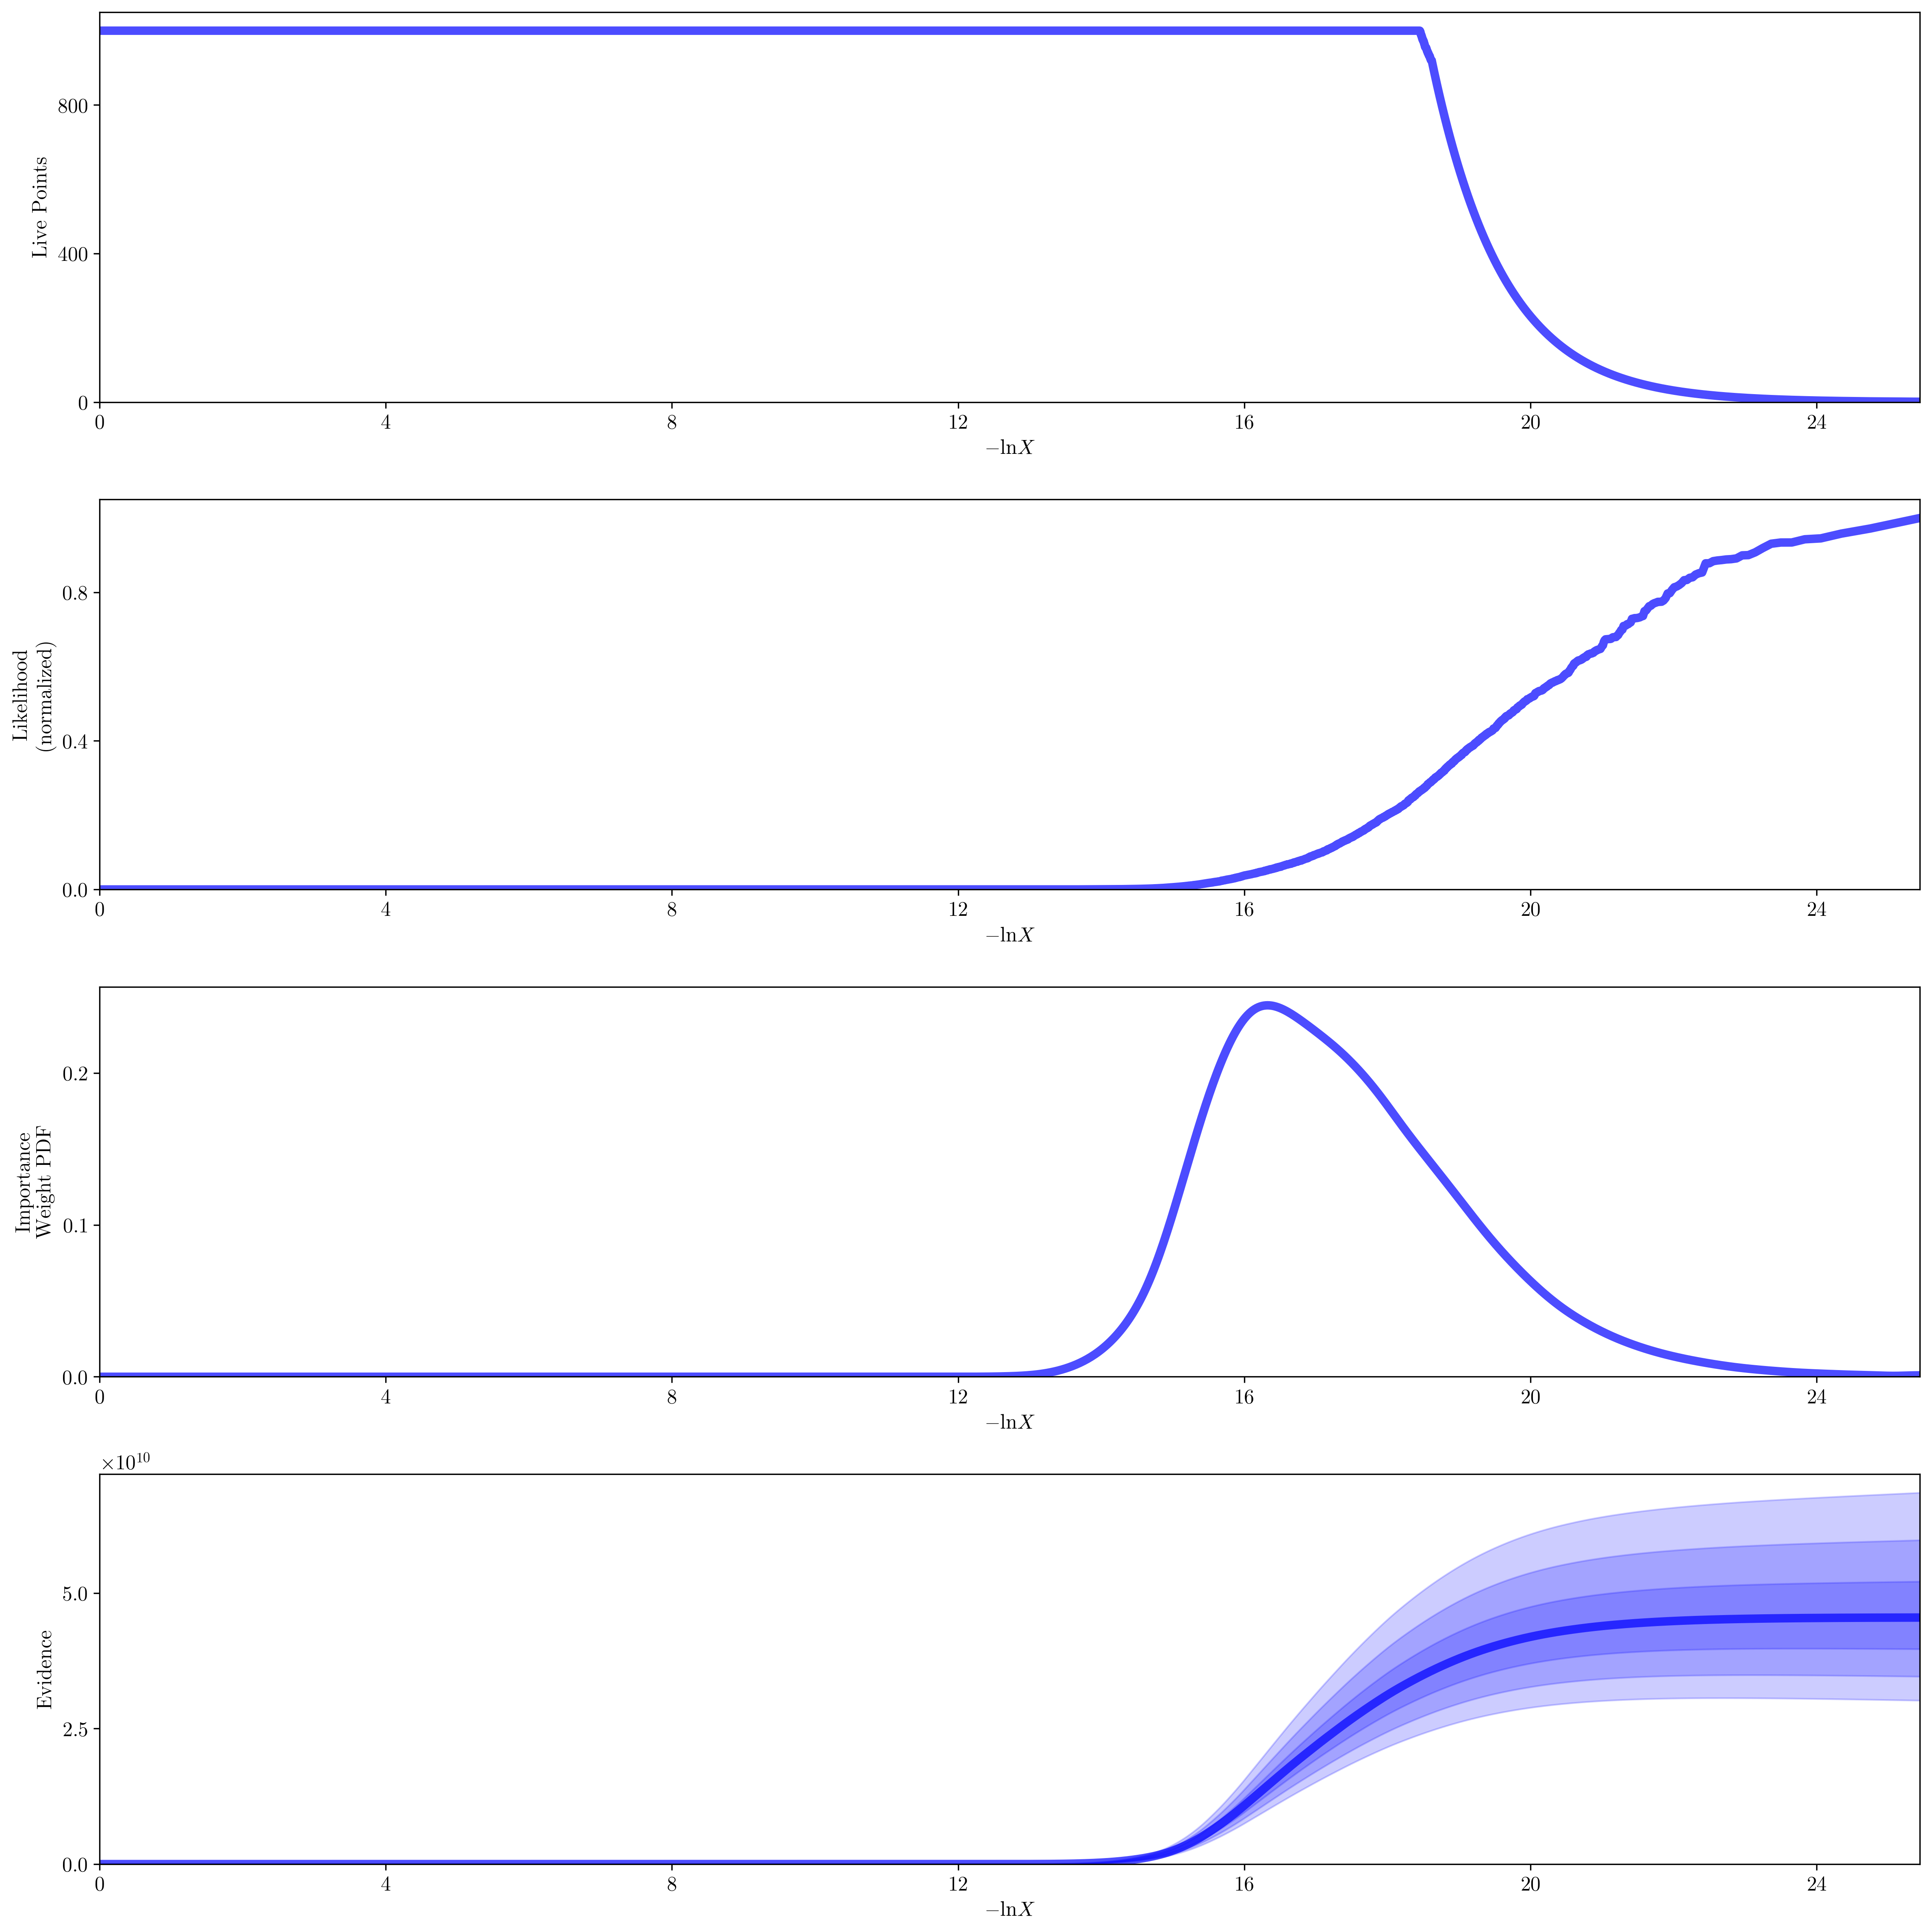

In [53]:
rfig, raxes = dyplot.runplot(results_4d)
rfig.tight_layout()

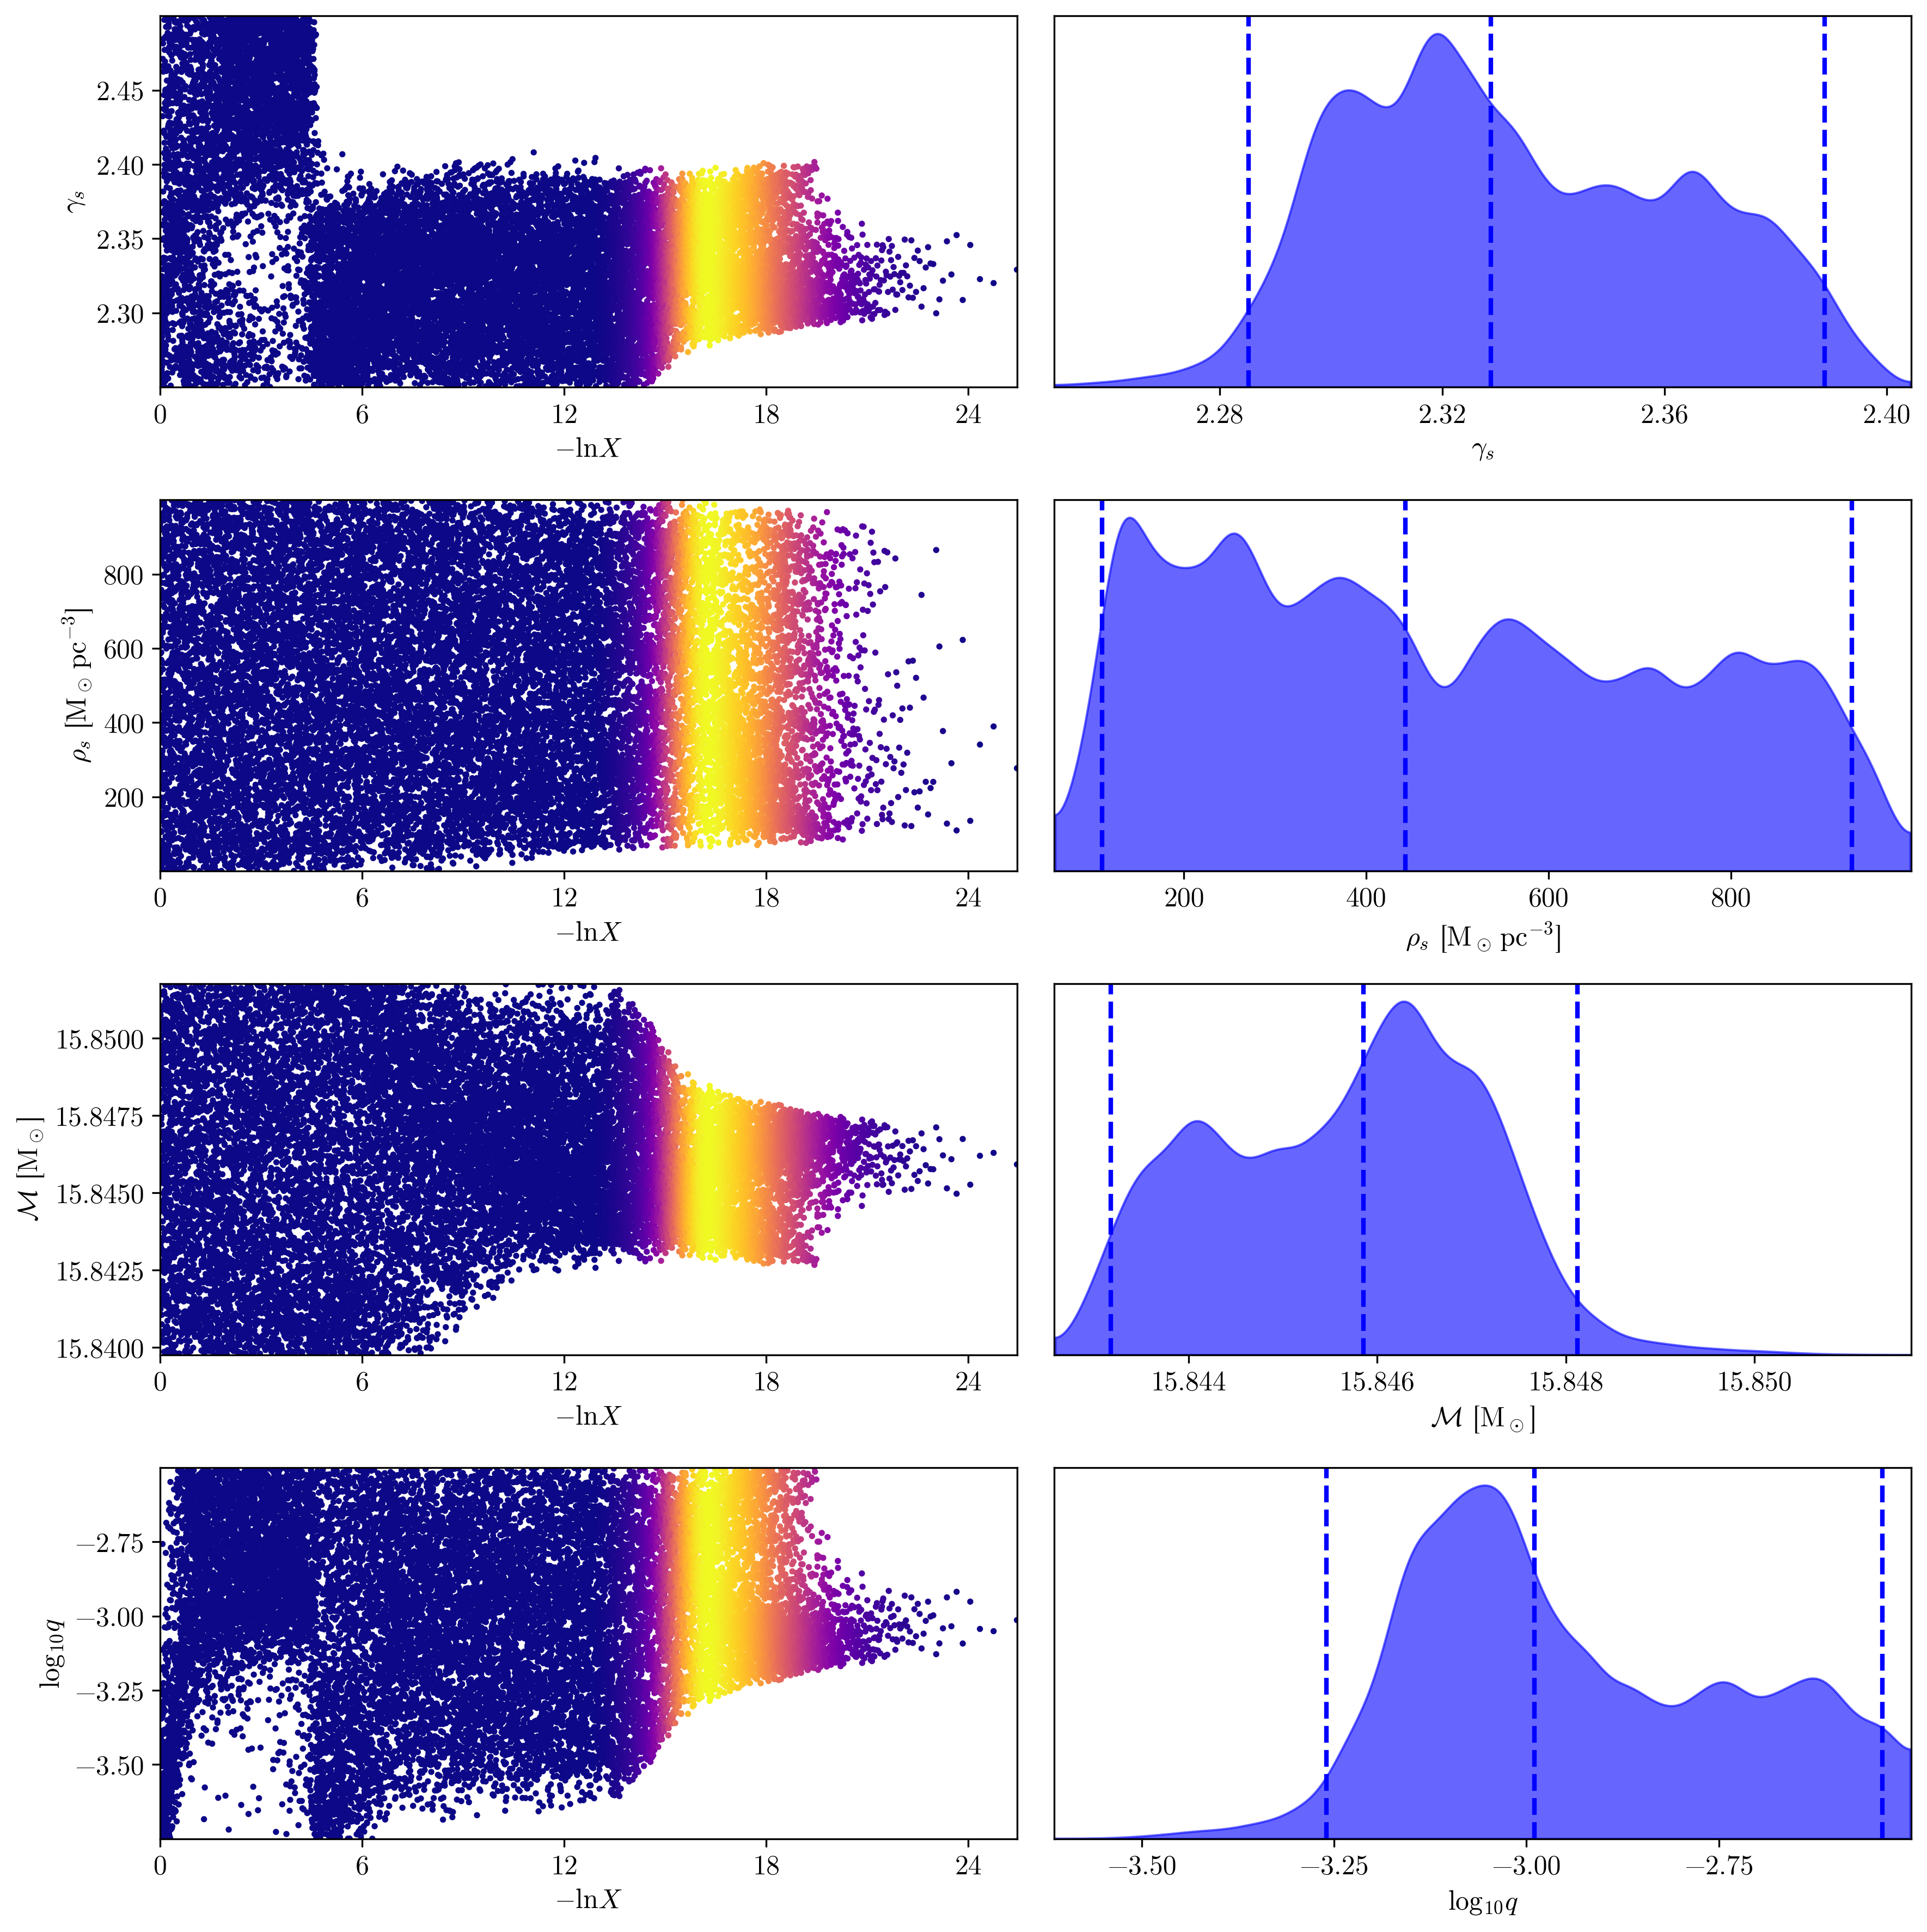

In [54]:
tfig, taxes = dyplot.traceplot(results_4d, labels=labels)
tfig.tight_layout()

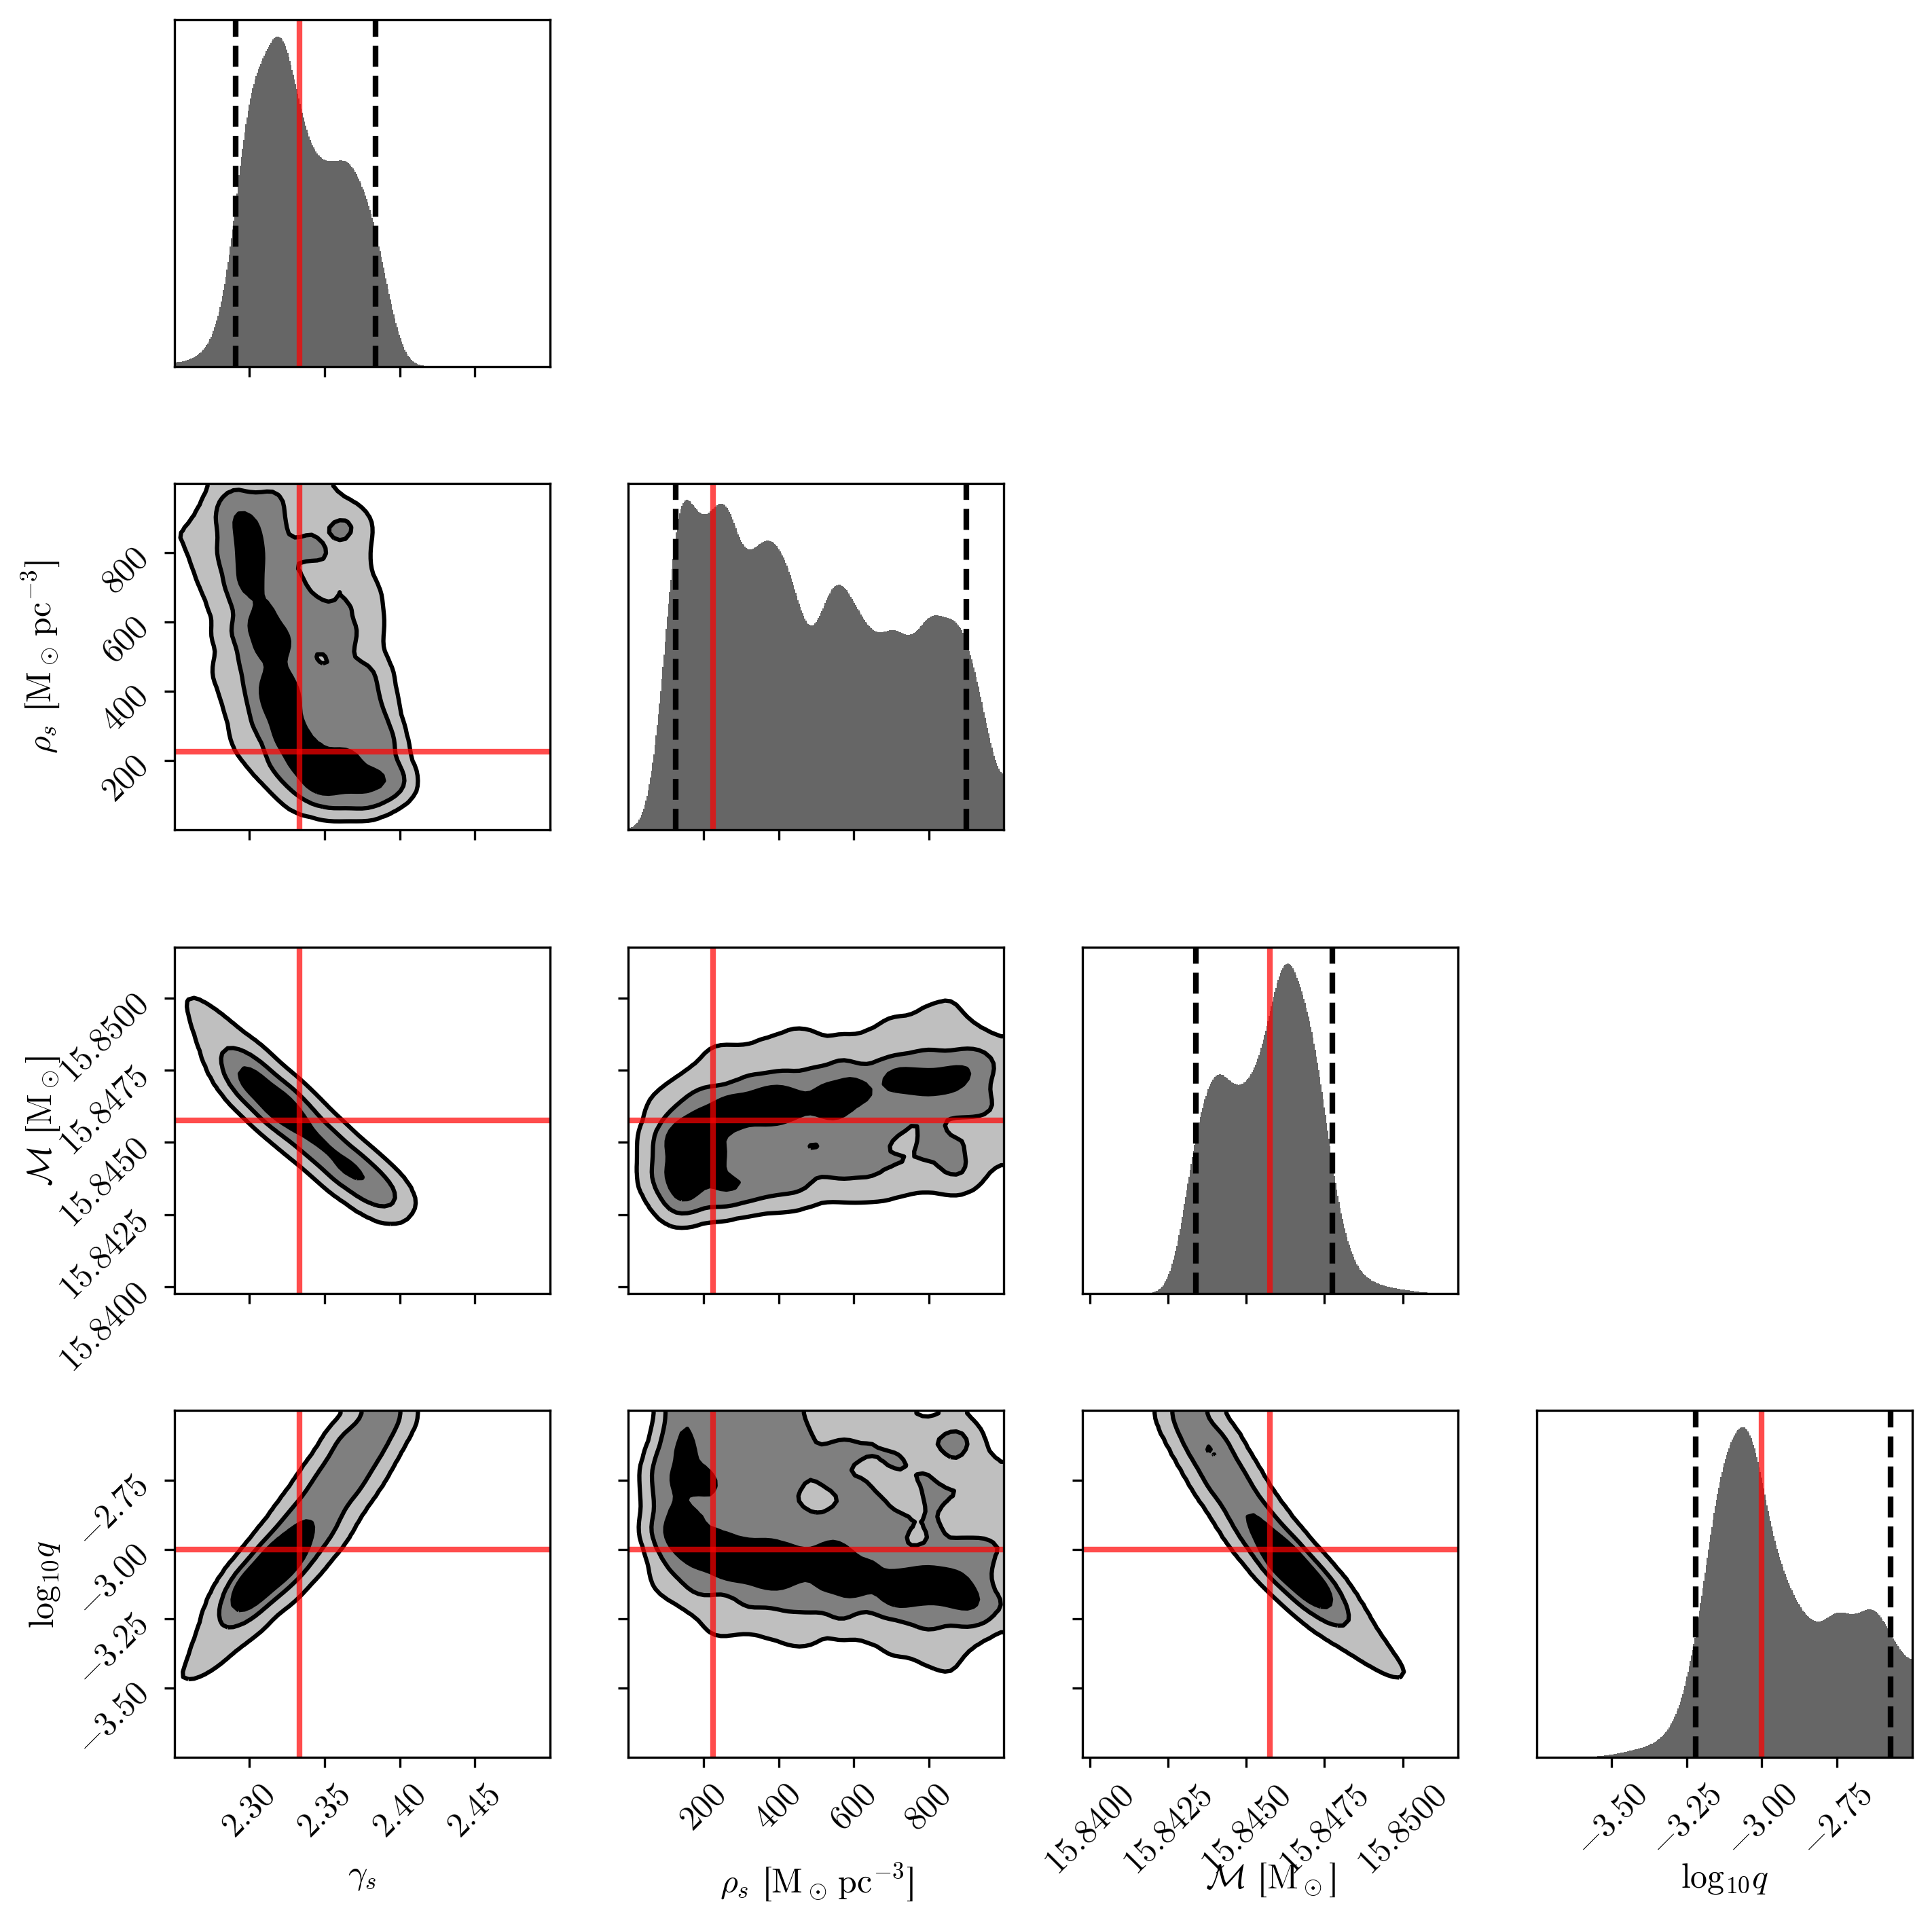

In [77]:
cfig, caxes = dyplot.cornerplot(
    results_4d,
    labels=labels,
    quantiles=[1 - 0.95, 0.95],
    quantiles_2d=[1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]],
    smooth=0.03,
    truths=(
        gamma_s,
        rho_s / (MSUN / PC ** 3),
        dd_s.M_chirp / MSUN,
        jnp.log10(dd_s.q),
    ),
    span=[1, 1, 1, 1]
)
cfig.tight_layout()

## Vacuum system with FFT likelihood

In [22]:
# @jax.jit
def logL_v(x):
    M_chirp = x[0] * MSUN
    vb_h = VacuumBinary(
        M_chirp,
        dd_s.Phi_c,  # fixed
        dd_s.tT_c,  # value doesn't matter
        dd_s.dL_iota,  # value doesn't matter
        dd_s.f_c,  # should give largest-possible likelihood
    )
    return loglikelihood_fft(vb_h, dd_s, f_l, dd_s.f_c, 100000, 3000)

In [23]:
dM_chirp_MSUN_range_v = jnp.array([1.6e-4, 1.85e-4])
labels_v = [r"$\mathcal{M}$ [M$_\odot$]"]


def ptform_v(u):
    dM_chirp_MSUN = (dM_chirp_MSUN_range_v[1] - dM_chirp_MSUN_range_v[0]) * u[
        0
    ] + dM_chirp_MSUN_range_v[0]
    return jnp.array([dd_s.M_chirp / MSUN + dM_chirp_MSUN])

Check the likelihood directly

In [24]:
M_chirp_MSUN_grid = jax.lax.map(ptform_v, jnp.linspace(0, 1, 40).reshape([-1, 1]))
logLs = jax.lax.map(logL_v, M_chirp_MSUN_grid)

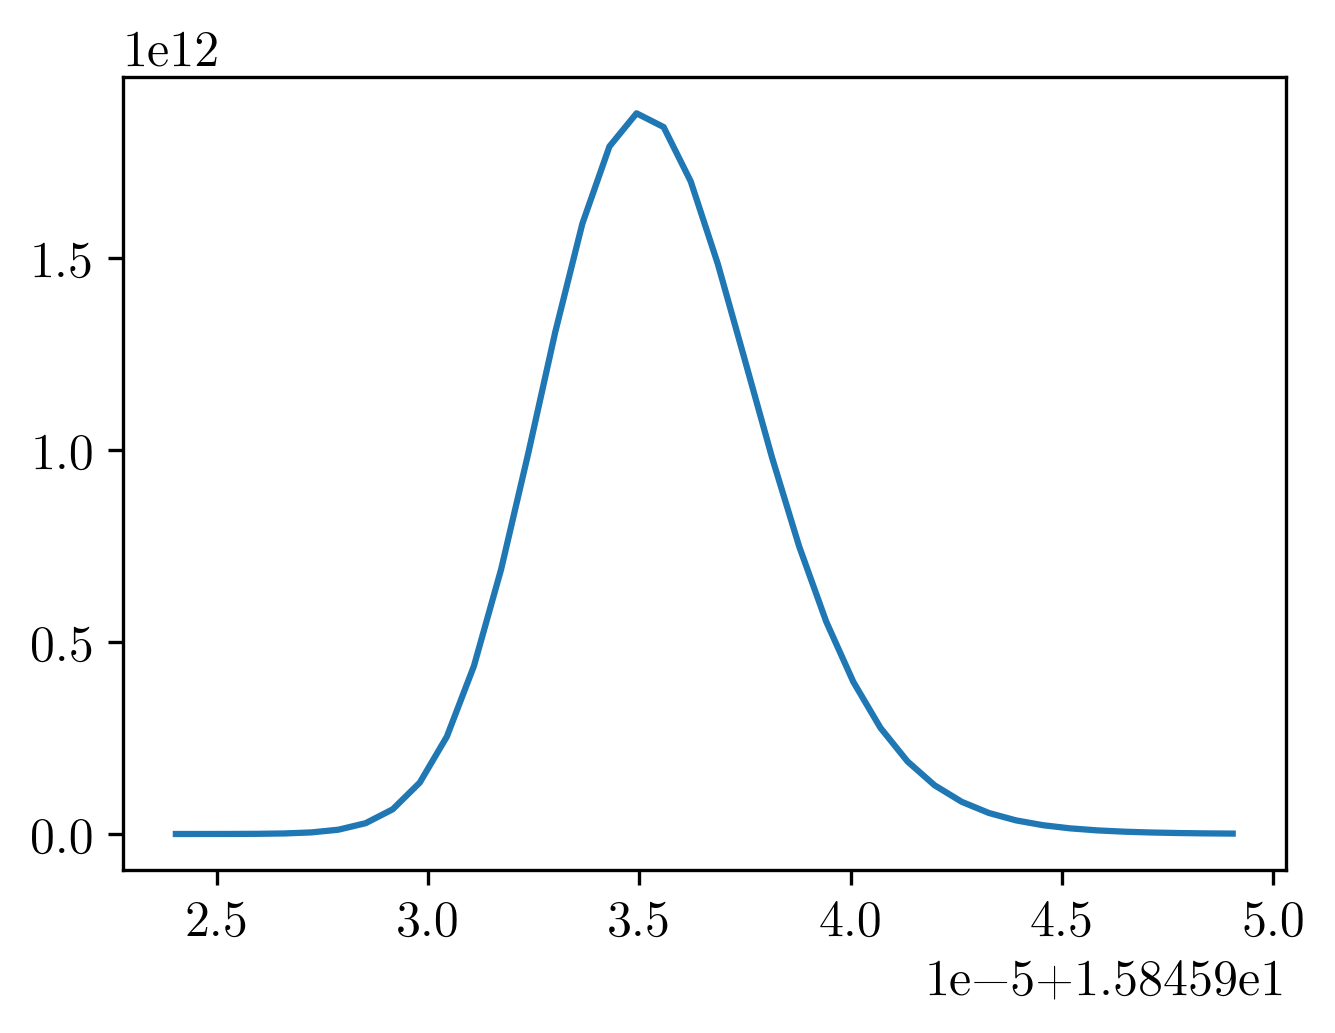

In [25]:
plt.plot(M_chirp_MSUN_grid, jnp.exp(logLs))

In [26]:
# Estimate maximum-likelihood vacuum system
idx_max = jnp.argmax(logLs)
dd_v_MLE = VacuumBinary(
    M_chirp_MSUN_grid[idx_max] * MSUN,
    dd_s.Phi_c,
    dd_s.tT_c,
    dd_s.dL_iota,
    dd_s.f_c,
)
print("MLE V params = ", dd_v_MLE.M_chirp[0] / MSUN)
print("True params  = ", dd_s.M_chirp / MSUN, "\n")

dN_naive = (Phi_to_c(f_l, dd_v) - Phi_to_c(f_l, dd_s)) / (2 * pi)
dN = (Phi_to_c(f_l, dd_v_MLE) - Phi_to_c(f_l, dd_s)) / (2 * pi)
print(f"dN (naive) = {dN_naive}")
print(f"dN (MLE)   = {dN[0]}\n")

print(f"logL(D|D)     = {loglikelihood_fft(dd_s, dd_s, f_l, dd_s.f_c, 3000, 3000)}")
print(f"logL(V_MLE|D) = {loglikelihood_fft(dd_v_MLE, dd_s, f_l, dd_s.f_c, 3000, 3000)}")

MLE V params =  15.845934936140285
True params  =  15.845764038704388 

dN (naive) = 92.3472252904477
dN (MLE)   = -10.373111393966727

logL(D|D)     = 49.808935411757446
logL(V_MLE|D) = 32.14328335223476


Run nested sampling

In [27]:
sampler_v = dynesty.NestedSampler(logL_v, ptform_v, 2, nlive=100, bound="multi")
sampler_v.run_nested()
results_v = sampler_v.results

815it [02:22,  5.73it/s, +300 | bound: 0 | nc: 1 | ncall: 4369 | eff(%): 25.521 | loglstar:   -inf < 28.262 <    inf | logz: 26.871 +/-  0.043 | dlogz:  0.001 >  0.309]


In [28]:
results_v.summary()

Summary
nlive: 300
niter: 815
ncall: 4369
eff(%): 25.521
logz: 26.871 +/-  0.043


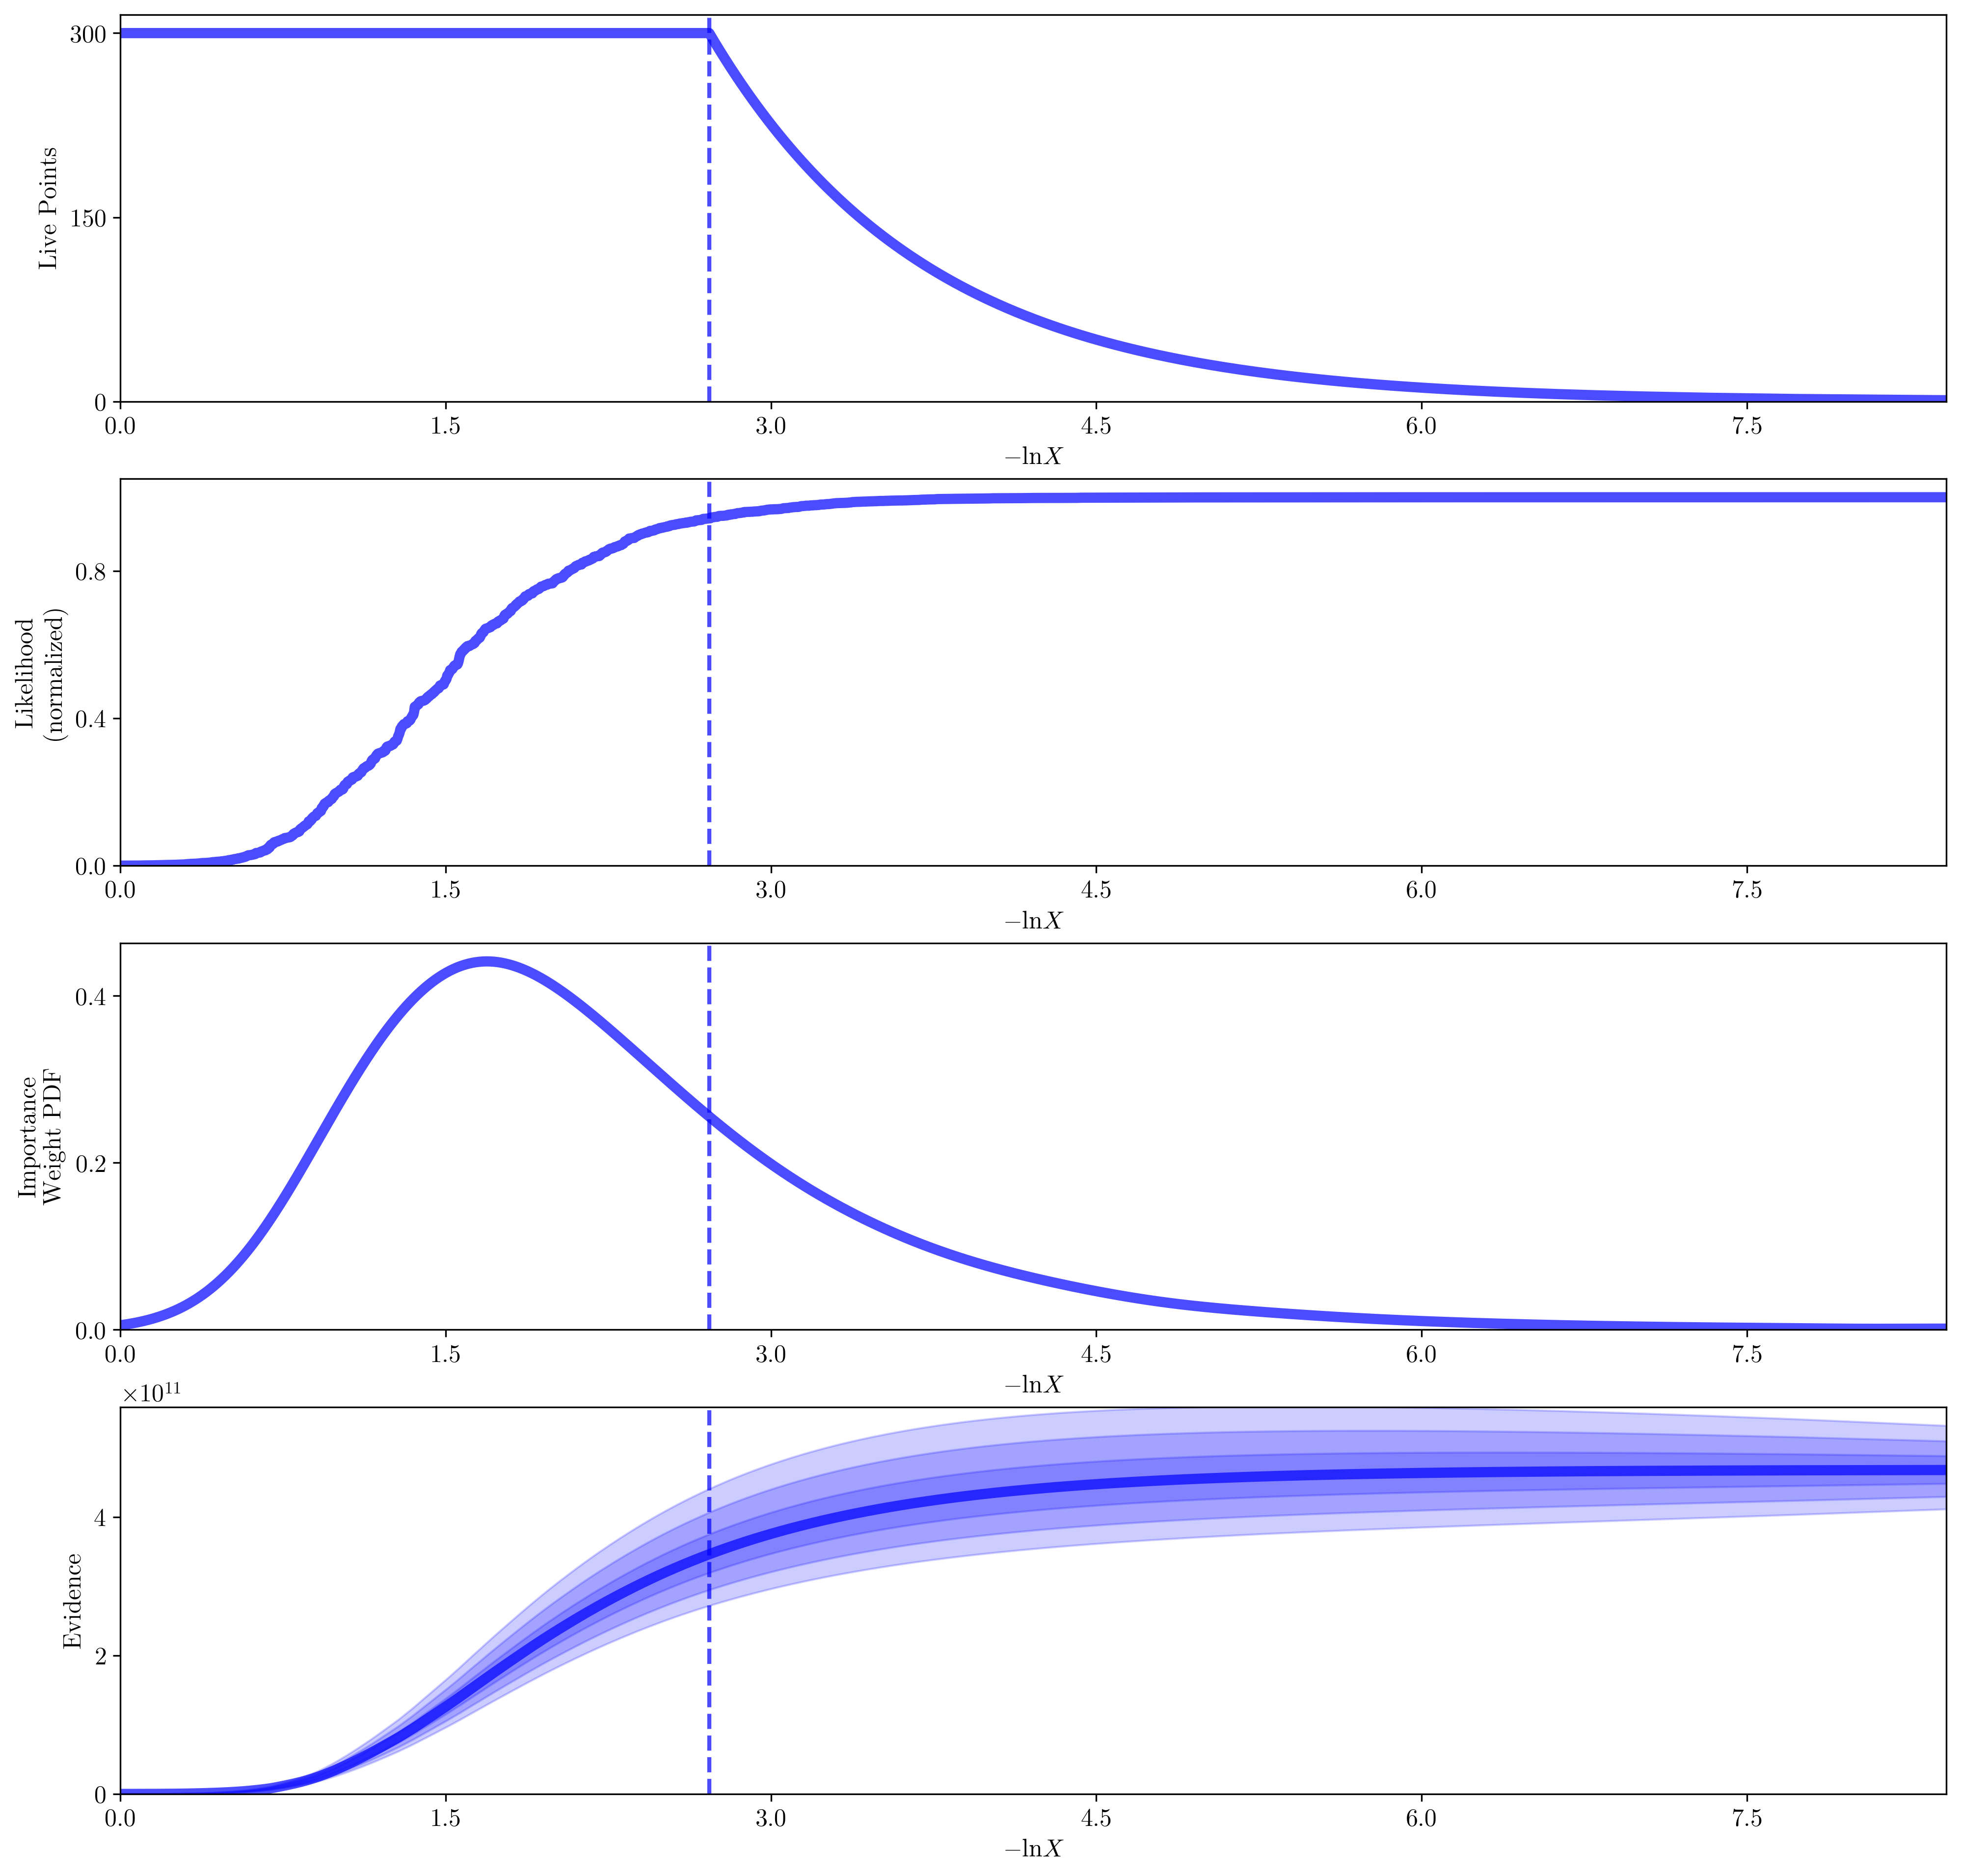

In [29]:
rfig, raxes = dyplot.runplot(results_v)

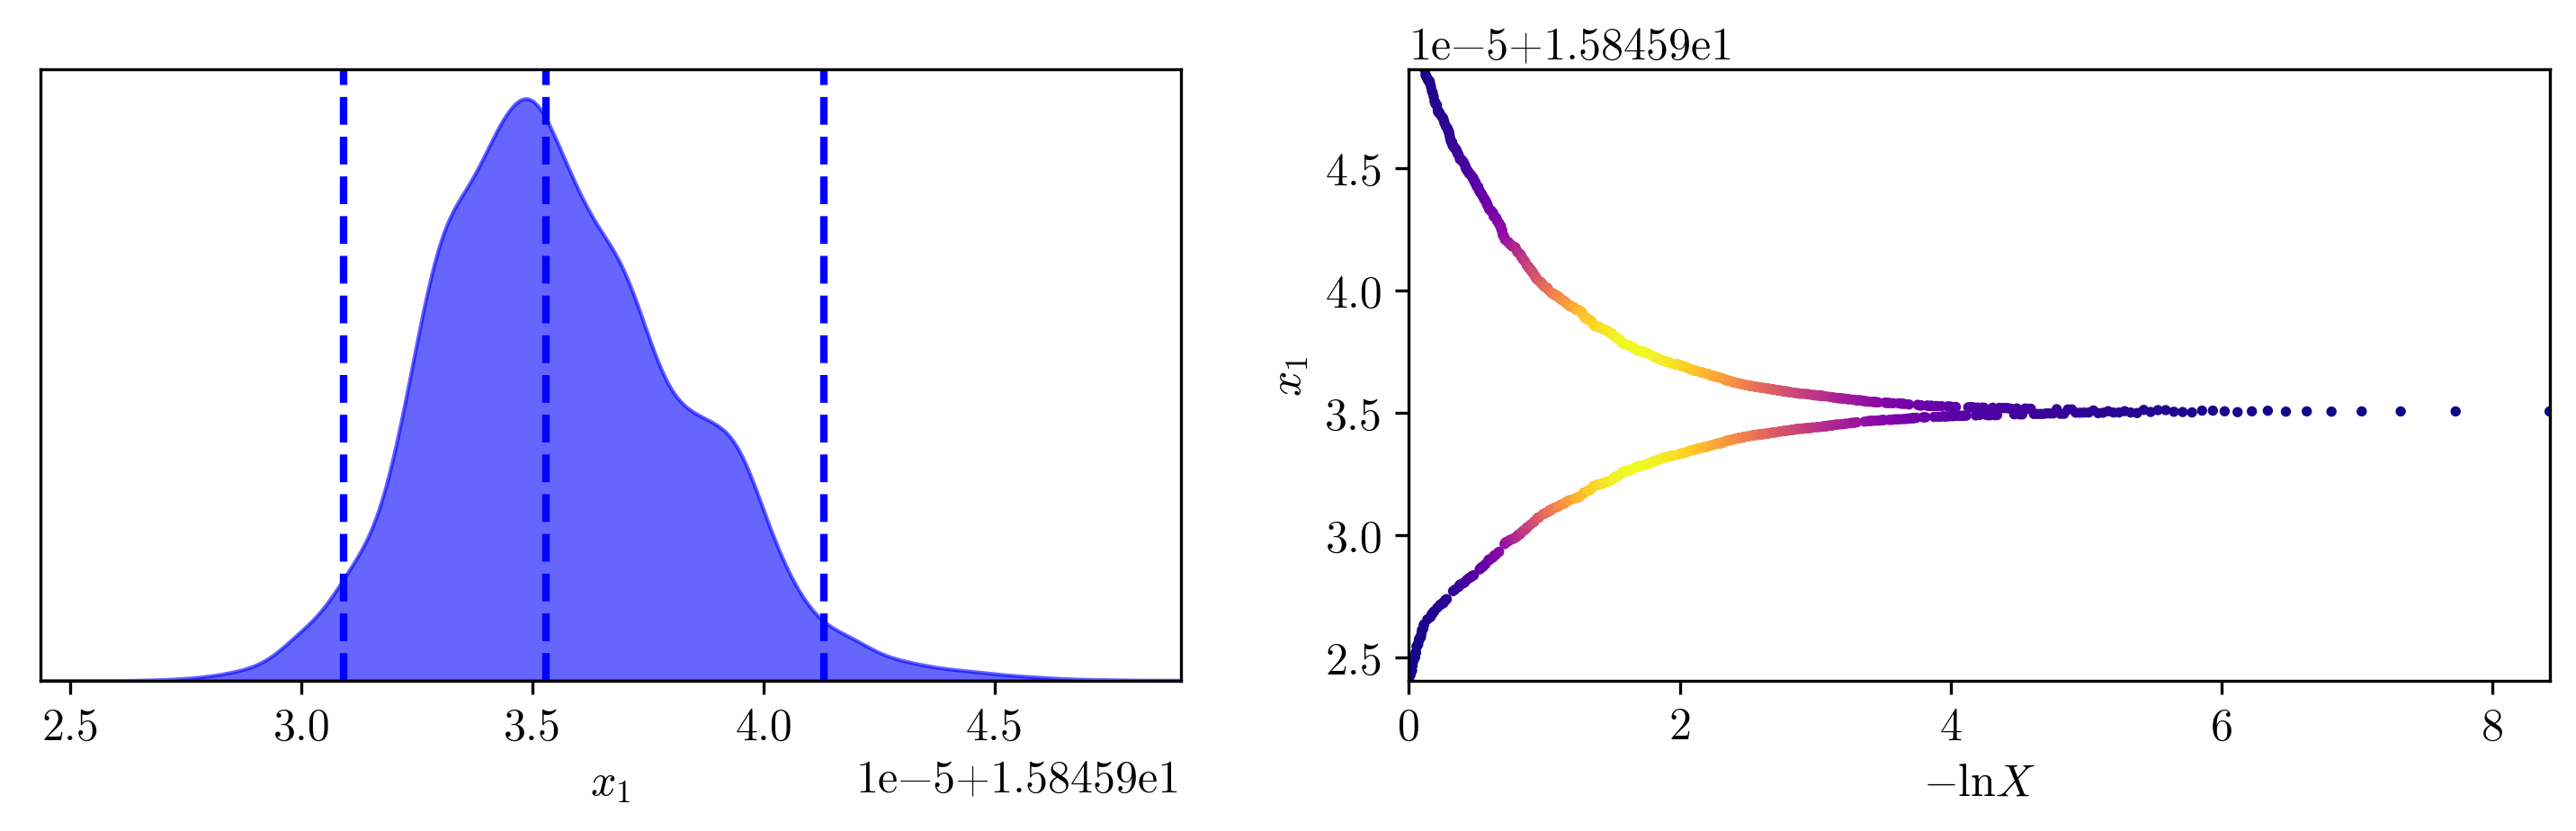

In [30]:
tfig, taxes = dyplot.traceplot(results_v)

p_v(x) = int dM p(x|M) p_v(M) = 1 / dM_v * int dM p(x|M)

p_d(x) = int dM dt p(x|M, t) p_d(M) p(t) = 1 / dM_d * int dM dt p(x|M, t) p(t)

K_NS = p_d(x) / p_v(x)

K = dM_d * p_d(x) / (dM_v * p_v(x))

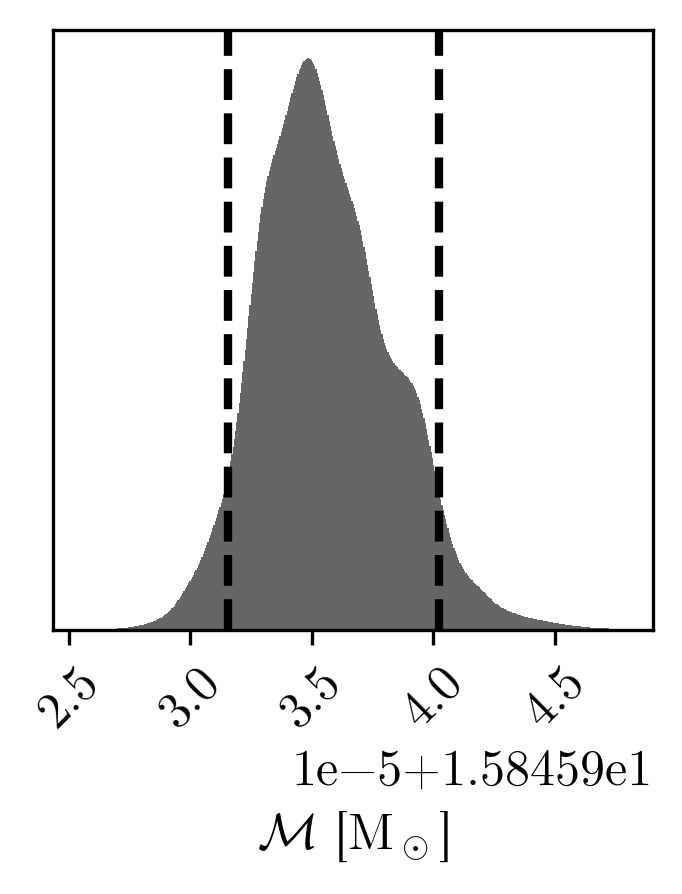

In [31]:
cfig, caxes = dyplot.cornerplot(
    results_v,
    labels=labels_v,
    quantiles=[1 - 0.95, 0.95],
    quantiles_2d=[1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]],
)

Bias in $\sigma$s

In [63]:
((15.8459 + 3.5e-5) - (dd_s.M_chirp / MSUN)) / 0.5e-5

DeviceArray(34.19225912, dtype=float64)

Evidence comparison!

In [32]:
bayes_fact_ns = jnp.exp(results.logz[-1]) / jnp.exp(results_v.logz[-1])
bayes_fact_est = (
    (dM_chirp_MSUN_range[1] - dM_chirp_MSUN_range[0])
    / (dM_chirp_MSUN_range_v[1] - dM_chirp_MSUN_range_v[0])
    * bayes_fact_ns
)
print(f"K >= {bayes_fact_est}")

K >= 2856.437058076377
